# Deep Learning Project Nicolas Lapautre
## 


We are going to solve a simple optimal growth model with one agent, a simplified version of [Brock and Mirman (1972)](https://assoeconomiepolitique.org/wp-content/uploads/Brock-et-Mirman-1972.pdf).  

The agent aims to maximize her time-separable life time utility (where utility is the log function), subject to her budget constraint ( i.e the goal is to find the best consumption plan at each step $C_t$ that maximizes lifetime utility, subject to daily limits of how much we can consume):
\begin{align}
&\max_{\left\{c_{t}\right\}_{t=0}^{\infty}} \sum_{t=0}^{\infty} \beta^{t} \ln\left(C_{t}\right)\\
\text{s.t.} \quad & K_{t+1} + C_{t} = Y_t + (1 - \delta) K_t
\end{align}
where $Y_t = K_{t} ^ \alpha$.

Here the second equation is called the budget constraint, where $C_t,K_t,Y_t$ are respectively consumption, saving, and income/production at time t. We assume that whatever is saved is used to produce income in the next period. We also choose an initial capital at time zero that the agent will start with($K_0$). Note: This is more of a macroeconomic model, so it's not modelling an individual person, but I am trying to explain it intuitively


Here we assume full depreciation, i.e. $\delta=1$, this allows the problem to have an analytical solution:

\begin{align}
K_{t+1} = \beta \alpha K_{t}^{\alpha}
\end{align}

We traditionally could numerically solve the above problem by using any global solution algorithm such as the value function iteration or policy iteration.  
Here we use a deep neural network to find the solution following [Azinovic et al. (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575).  

### Expressing the problem Recursively


The above problem can be formulated recursively, this is true as long as the problem is convex or something.. Intuitively, since they live infinitely, and everyday they are faced with the same problem, you can reexpress the problem, as comparing the value that saving a certain amount gives me today, compared to tomorrow (similarly to reinforcement learning problems).

\begin{align}
V(K_t) &= \max_{K_{t+1}} [\ln\left(C_{t}\right)+\beta V(K_{t+1})]\\
\text{subject to: }C_t &= K_t^\alpha + (1 - \delta) K_t - K_{t+1}
\end{align}
Plugging in the budget constraint, substituting $C_t$ by the rhs of the equation above, we obtain:
\begin{align}
V(K_t) &= \max_{K_{t+1}} \ln\left(K_t^\alpha + (1 - \delta) K_t - K_{t+1}\right)+\beta V(K_{t+1}).
\end{align}
We notice that, $C_t$ disappears, and hence we are now optimizing in terms of $K_{t+1}$ (how much I'm saving for tomorrow) and not consumption anymore

Hence, $K_{t+1}=f(K_t)$ which is a function of $K_t$ $f(K_t)$ denotes the **policy**, so $K_t$ is the state. 

The traditional way to solve this, is to find a grid of values k, and iterate V until it solves the problem. The issue with this is that if we have a high dimensional problem: $ K= [x,y,z]$ then we would have too many values to solve V for. This is where this neural network approximation is useful.

### How we find a loss


We are interested in approximating the policy $K_{t+1}=f(K_t) $ through a neural network. To do this we approximate $f(\cdot)$ with a neural network $\mathcal{N}(\cdot)$, such that $\mathcal{N}(K_t) \approx f(K_t) = K_{t+1} $.

To find the loss, we use the fact that the optimal solution will satisfy a few equation, just like how when a function is at it's maximal value, the equation $f'(x)=0$ is satisfed . Hence we can plug these optimality condition in the loss of the neural network. 




Taking the first order condition with respect to $K_{t+1}$, we obtain

\begin{align}
0 &= -\frac{1}{\underbrace{K_t^\alpha + (1 - \delta) K_t - K_{t+1}}_{=C_t}}+\beta \frac{d V(K_{t+1})}{d K_{t+1}}
\end{align}
Applying the [Envelope theorem](https://en.wikipedia.org/wiki/Envelope_theorem), we obtain
\begin{align}
\frac{d V(K_{t})}{d K_{t}} &= \frac{d}{d K_{t}}\ln\left(\underbrace{K_t^\alpha + (1 - \delta) K_t - K_{t+1}}_{=C_t}\right)\\
&= \frac{1}{C_t}\left(\frac{dK_t^\alpha}{dK_t} + (1 - \delta)\right)\\
&= \frac{1}{C_t}\left(\underbrace{\alpha K_{t}^{\alpha - 1}}_{=:r_t} + (1 - \delta)\right)\\
&= \frac{1}{C_t}\left(r_t + 1 - \delta\right).
\end{align}
Applying this result to replace $\frac{d V(K_{t+1})}{d K_{t+1}}$ in the first order condition, we obtain
\begin{align}
0 &= -\frac{1}{C_t} + \beta \frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)
\end{align}
where 
\begin{align}
r_{t+1} &= \alpha K_{t+1}^{\alpha - 1}\\
C_t &= K_t^\alpha + (1 - \delta) K_t - K_{t+1}\\
C_{t+1} &= K_{t+1}^\alpha + (1 - \delta) K_{t+1} - K_{t+2}.
\end{align}

This can be used as an error function, however in order to be able to interpret it as a minimization problem we reformulate it.
\begin{align}
0 &= -\frac{1}{C_t} + \beta \frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)\\
\Leftrightarrow \frac{1}{C_t} &= \beta \frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right) \\
\Leftrightarrow C_t &= \frac{C_{t+1}}{\beta \left(1 - \delta + r_{t+1}\right)} \\
\Leftrightarrow 1 &= \frac{C_{t+1}}{C_t \beta \left(1 - \delta + r_{t+1}\right)}  \\
\Leftrightarrow 0 &= \frac{C_{t+1}}{C_t \beta \left(1 - \delta + r_{t+1}\right)} - 1.
\end{align}
Hence we know the equation above must be zero in optimum. Hence we will encode this equation as the **loss function** to train the neural network. 
I.e. we will train the neural network $\mathcal{N}(\cdot)$ such that the implied policy fullfills the equation above. (Remember we assume $\delta=1$, so $(1-\delta)=0$ here and throughout the notebook)



### Problems with this technique 



The above equilibrium function that is used in the loss can't be evaluated correctly if consumption or the level of capital are not positive. As negative consumption implies imaginary number of utility. Since a neural network is initialized randomly, this is not guaranteed by itself. The author  addresses the above problem by approximating  the savings rate $s_t$ instead of $K_{t+1}$, such that $K_{t+1} =  Y_t s_t =  Y_t \mathcal{N}(K_t)$. Since $Y_t$ is completely determined given the state $K_t$, this formulation still encodes the policy $K_{t+1}$, albeit more indirectly. They then use a sigmoid activaiton function such that they ensure that $s_t\in(0, 1)$ and hence $K_{t+1}\geq 0$ and $C_t\geq 0$. In this case, this enforces the neural network to output feasible values, as the the saving rates being between 0 and 1 guarantees this. Hence a simple sigmoid will ensure that the network always output feasible levels. 


The limitation is that is not reproducable for any models : when the model is too complicated we cannot simplify the problem to finding $s_t$, and hence a simple sigmoidal activation function will not work. For example in the paper by the same author  [The climate in climate economics ](https://academic.oup.com/restud/article-abstract/92/1/299/7593489?redirectedFrom=fulltext&login=false), they are not able to find a simplification like saving rates, and have to keep next period capital as the prediction. 

To overcome this, the author use two methods: 
1. Adds a punishment term to the loss function: if the implied consumption is negative, add a punishment of the form $max(-c_t,0)^2$ 

2. When they're exist a global lower or upper bound, enforce it with a scaled sigmoid activation. A scaled sigmoid is such:  $a*\sigma(x)+b$, where $\sigma()$is the sigmoid activation, so that it has a minimum of b, and maximum of a.

A limitation I see with the punishment strategy 1. is that it needs to be calibrated. Too strong of a punishment may lead to bad training, while too weak of a punishment may be useless. 

An issue with 2. is that the scaled sigmoid can only enforce the global maximum. Since for each $K_t$, $C_t$ being positive implies that $K_{t+1}$ can be at most $K_t^\alpha$ i.e $0 \leq K_{t+1} \leq K_t^\alpha$.

If we train our neural network with values of capital between $[0.1,1]$. Each values of the set will imply different maximums on the next period capital, the maximum of the maximums is for $K_t=1$, where $K_{t+1}$ is at most $1^\alpha=1$, but enforcing this maximum will potentially lead to infeasible outputs when we try to predict smaller values below 1. However if we make a sigmoid that is bounded by the smallest value, i.e the next period capital when $K_t=0.1$, then likewise we will not be able to output any higher values, such as 1. 

I attempt to overcome the need of these two methods by using an activation that will dynamically adjust based on the current capital value. That is, the activation will change depending on the current capital value, so that it enforces the bound for each values. Since for any input $K_t$ the output is maximally $K_t^\alpha$, I define a custom activation layer that will output a scaled sigmoid, where the scale depends on the input to the neural network.

This is in the spirit of encoding prior knowledge based on economics directly into the neural network architecture (relatedly, [Kahou et al. (2021)](https://www.nber.org/papers/w28981) and [Han et al. (2022)](https://arxiv.org/abs/2112.14377) show how symmetry can be encoded into the neural-network architecture and [Azinovic and Žemlička (2023)](https://arxiv.org/abs/2303.14802) introduce market clearing neural network architectures.).




### For what values do we solve it to change//

We know that the true solution takes the form of $K_{t+1} = \beta \alpha K_{t}^{\alpha}$ this is a contractive mapping ( $K_{t+1}<K_t$ for any positive value of K ), and has fixed point solution, $(\beta \alpha)^{1/(1-\alpha)} \approx 0.2$. I.E for any starting capital level, the consumer will at some point up end up with a constant capital of 0.2. 

Originally in the notebook the authors only solve for K values between 0.1 and 1. Ideally we would want to be able to simulate any situation, such as where initial value of K is very high.

I started by solving for the same range $[0.1, 1]$ as the author. However I will look at how it generalizes for larger values later on. 



Since this model can be solved analytically for the full depreciation case, we implement the analytical solution (so that we can later check the solution found by the neural network).

#### Deep neural network 

In this section, we define the architecture of the deep neural net.  
Our goal is for the neural network to approximate the savings rate $s_t$, such that $K_{t+1} = Y_t s_t \approx Y_t \mathcal{N}\left(K_t \right)$.  
The neural network input is hence a 1-dimensional state $K_t$ and the output is the 1-dimensional savings rate $s_t$.

  We assume the following structure of layers and activation functions: 
  
    * Layer 1: the input layer, 1 neuron corresponding to the capital stock $K_t$  
    * Layer 2: the first hidden layer, 50 neurons and is activated by Relu  
    * Layer 3: the second hidden layer, 50 neurons and is activated by Relu  
    * Layer 4: the output layer, 1 neuron corresponding to the next period capital $K_{t+1}$. We here try out different activations mentionned below.



In [51]:
# Import necessary liblaries
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
import random
import time


import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.size"] = 15

%matplotlib inline

print("Version of tensorflow is {}".format(tf.__version__))

Version of tensorflow is 2.18.0


### Activations to solve the problem of unfeasible predictions 

To avoid the problem of predicting values that would induce negative consumption I created activations that will only output values within the acceptable range. I started off with the idea of a custom relu "truncated_relu()". This is alike a normal relu however anything above the implied upper bound is truncated to the upper bound, similarlu to relu6. 

However using this activation I noticed that many times the neural network failed to train. Half of the time the NN outputed zero and a training loss of 1 straight from intitialition. After one step of training it outputted nan values of loss, and all the weights were nan. I attempted to solve this with positive bias initalization, leaky relu, batch norm, but all these methods either failed, or led to bad loss.

This prompted me to make a custom scaled sigmoid activation "scaled_sigmoid()", which outputs $y^{\alpha} * \sigma(x)$, where y is the data/current capital inputted to the neural network, and x is the previous hidden layer's output. This will enforce the upper bound $0 \leq K_{t+1} \leq K_t^{\alpha}$ as the sigmoid activation is between 0 and 1, scaling it by  $K_t^{\alpha}$ will make the range between $[0,K_t^{\alpha}]$ .

This can also be represented as a special skip connection that connects the input y to the final output. 

To do this we pass a normal sigmoid activation through the final output. Then to scale it, we connect a transformed input y to this sigmoid activated output. More specifically we take the input/data point y, put it to the power alpha, and then multiply the final output by $y^{\alpha}$ . This connection between the input and output, is alike a skip connection, and effectively acts like the sigmoid scalar. I created this version through scaled_sigmoid_2(). It is effecitvely the same as the previous scaled_sigmoid(), however it separates the task by making the last layer go through sigmoid, then multiplying through a special layer, that is alike a skip connection.

It was difficult to understand how to code this custom activation, it was particularly tricky because it took as input the neural network input. I used https://keras.io/guides/making_new_layers_and_models_via_subclassing/ to understand how to do this. 

This technique also made me wonder whether it is parallelizable.


Is this better then coding it in the loss? can you otherwise put both together? 
is scaled sigmoid not as good? like if sigmoid can at least take all values, then wouldnt it be the same? 
how to implement it better, make it  parralelizable.


In [189]:
# Here I define the global parameters used throughout the notebook.
alpha = 0.36  # Capital share in the Cobb-Douglas production function
beta = 0.99  # Discount factor
delta = 1.0 # depreciation of capital
epsilon = 1e-5 #small value to avoid numerical errors

In [1]:
def truncated_relu(z, input_x):
    """
    Truncated ReLU activation function.

    Args:
        z: Input to the activation function (output of the previous layer).
        input_x: Original input to the neural network.
    
    Returns:
        Truncated ReLU output.
    """
    # remove negative values to small numerical to avoid imaginary number
    x_safe = tf.maximum(input_x, 0)

    # Calculate the upper bound to ensure positive consumption
    upper_bound = 6 #(1 - delta) * x_safe + K.pow(x_safe, alpha)
    
    # Apply standard ReLU to z
    relu_z = K.relu(z)
    
    # Truncate the ReLU output at the upper bound
    truncated_output = tf.where(relu_z < upper_bound, relu_z, upper_bound)
    
    return truncated_output

In [74]:
def scaled_sigmoid(x, input_x):
    """
    Scaled sigmoid activation function.
    
    Args:
        z: Input to the activation function (output of the previous layer).
        input_x: Original input to the neural network.
    
    Returns:
        Scaled sigmoid output.
    """
    
    x_safe = tf.maximum(input_x,0)
    
    # Calculate the upper bound to ensure positive consumption
    max_value =  tf.pow(x_safe, alpha)
    
    # Apply a sigmoid to x to get values in [0, 1]
    sigmoid_output = tf.sigmoid(x)
    
    return max_value * sigmoid_output


In [75]:

def scaled_sigmoid_2(x, input_x):
    """
    Scaled sigmoid activation function.
    
    Args:
        z: Input to the activation function (output of the previous layer).
        input_x: Original input to the neural network.
    
    Returns:
        Scaled sigmoid output.
    """
    
    x_safe = tf.maximum(input_x,0)
    
    # Calculate the upper bound to ensure positive consumption
    max_value = tf.pow(x_safe, alpha)
    
    
    return max_value * x

In [76]:
class TruncatedReLULayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(TruncatedReLULayer, self).__init__(**kwargs)

    def call(self, inputs):
        """
        Apply the truncated ReLU activation.
        
        Args:
            inputs: A list containing [input_x, z].
                   - input_x: The original input to the neural network.
                   - z: The output of the previous layer.
        """
        input_x, z = inputs
        return truncated_relu(z, input_x)

In [77]:
class ScaledSigmoid(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ScaledSigmoid, self).__init__(**kwargs)

    def call(self, inputs,):
        """
        Apply the scaled sigmoid activation.
        
        Args:
            inputs: A list containing [input_x, z].
                   - input_x: The original input to the neural network.
                   - z: The output of the previous layer.
        """
        input_x, z = inputs
        return scaled_sigmoid(z, input_x)

In [78]:
class ScaledSigmoid_2(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ScaledSigmoid_2, self).__init__(**kwargs)

    def call(self, inputs,):
        """
        Apply the scaled sigmoid activation.
        
        Args:
            inputs: A list containing [input_x, z].
                   - input_x: The original input to the neural network.
                   - z: The output of the previous layer.
        """
        input_x, z = inputs
        return scaled_sigmoid_2(z, input_x)

##### We define the neural network

Below is the Neural Network class I build with Keras. It has three layers, with an input of 1 dimension, current capital, a first dense hidden layer of 50 neurons, a second dense hidden layer of 50 neurons, and an output of one neuron, which is the approximated next period capital.

It has many settings, such as which activation to use in each layer, whether to use batch norm. Some functionalities will only be used later in the notebook.

I defined the loss/cost function: "compute_loss()" that uses the equilibrium function as defined above. Furthemore I introduce a new data generating function that is different from the original one used in the notebook. I will explore which one is better later.

I made some custom functions such as weight printing, for checks. All the functions are explained with comments. 

In [191]:
from tensorflow.keras import Input, Model, initializers,layers
import tensorflow as tf
from tensorflow.keras.layers import Dense, Lambda



class NeuralNetwork:
    def __init__(self,costum_activ=False,sigmoid_activ=True,use_bn1=False,use_bn2=False, activation1='relu',activation2='relu',activation3='sigmoid',
                 initializer=None,learn_rate=0.001):
        """ 
        Parameters:
            costum_activ (bool): If True, uses a custom activation function for the output layer.
            sigmoid_activ (bool): If True and `costum_activ` is True, applies the scaled sigmoid activation. 
            If False  and `costum_activ` is True applies the truncated ReLu activation
        
            use_bn1 (bool): If True, applies batch normalization to the first hidden layer.
            use_bn2 (bool): If True, applies batch normalization to the second hidden layer.

            activation1 (str): Activation function for the first hidden layer.
            activation2 (str): Activation function for the second hidden layer.
            activation3 (str): Activation function for the output layer (used if `costum_activ` is False).
            
            initializer (tf.keras.initializers): Weight initializer for the network.
            learn_rate (float): Learning rate for the Adam optimizer.
            seed(float): seed to set if you want to keep intialization constant
        """
        # Define the input shape
        num_input = 1
        num_hidden1 = 50
        num_hidden2 = 50
        num_output = 1

        # Input layer
        input_layer = Input(shape=(num_input,))

        # Hidden layers
        hidden1 = Dense(num_hidden1,activation=activation1, kernel_initializer=initializer)(input_layer)
        if use_bn1:
            hidden1 = tf.keras.layers.BatchNormalization()(hidden1)
        
        hidden2 = Dense(num_hidden2, activation=activation2,kernel_initializer=initializer)(hidden1)
        if use_bn2:
            hidden2 = tf.keras.layers.BatchNormalization()(hidden2)

        if costum_activ:
            raw_output = Dense(num_output,kernel_initializer=initializer)(hidden2)
            if sigmoid_activ:
                final_output = ScaledSigmoid()([input_layer, raw_output])
            else:
                final_output = TruncatedReLULayer()([input_layer, raw_output])
        else:
            final_output=Dense(num_output,activation=activation3,kernel_initializer=initializer)(hidden2) 
            
            #raw_output = Dense(num_output,activation=activation3,kernel_initializer=initializer)(hidden2)     
            #final_output=ScaledSigmoid_2()([input_layer, raw_output])

        self.model = Model(inputs=input_layer, outputs=final_output)
        self.optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate)

    def __call__(self, x):
        return self.model(x)
    
    def get_training_data(self,k_lb, k_ub, n_data):
        """ 
            Training data generator originally created in the notebook, computes n_data number of data points selected uniformly at random from the interval [k_lb,k_ub] which in out case is [0.1,1]
        Args:
            k_lb: lower bound
            k_ub: upper bound
            n_data: size of batch/number of data points generated
        Return:
            X(tensor): tensor of size (n_data,1). The data batch. 
        """
        return tf.random.uniform(shape=[n_data, 1],minval=k_lb,maxval=k_ub,dtype=tf.dtypes.float32)
    
    
    def get_training_data_2(self, k_lb, k_ub, n_data):
        """
            Data generator I created, computes n_data number of equally distanced data points in the interval [k_lb,k_ub], the lower and upper bound respectively. Which I then randomly shuffle.
            I also randomly perturb k_lb and k_ub such that the grid changes at each batch. Otherwise training on the same fixed points may lead to overfitting.
        Args:
            k_lb: lower bound
            k_ub: upper bound
            n_data: size of batch/number of data points generated
        Return:
            X(tensor): tensor of size (n_data,1). The data batch. 
        """
        perturb_value=(k_ub-k_lb)*0.01  #amount I perturb the bounds, 1% of the total length of the set

        start = tf.random.uniform(shape=[],minval=k_lb, maxval=k_lb + perturb_value)  #randomly perturbated lower bound 
        end=tf.random.uniform(shape=[],minval=k_ub - perturb_value, maxval=k_ub)    #same for upper bound

        X = tf.linspace(start, end, n_data) #equally distanced points

        X=tf.random.shuffle(X) #shuffle the grid points 

        X = tf.reshape(X, (-1, 1))  # Ensure X has shape (batch size, 1)
        
        return X

    def compute_loss(self,X,punish=False):
        """ 
        Compute the mean squared error with the equilibrium condition.

        Args:
            X (tensor): the training batch
        Return:
            loss(tensor): MSE loss of batch
        """

        # Read out the state 
        K_t = X
        
        # Rompute output today
        Y_t = K_t ** alpha

        # Use the neural network to predict the next period capital
        K_next= self.model(X)


        C_t= Y_t - K_next
        
        # Predict capital in two periods
        K_2next= self.model(K_next)

        C_next= K_next**alpha - K_2next

        R_tplus1 = alpha * K_next ** (alpha - 1.)

        # Equilibrium conditions/loss function below 
        
        errREE = 1 - C_next / (beta * (C_t ) * (R_tplus1 + 1. - delta)+ epsilon)
        if punish:
            errREE = 1 - C_next/(beta * (C_t ) * (R_tplus1)+ epsilon) + epsilon**(-1)*tf.maximum(-C_t,0) #+ epsilon**(-1)*tf.maximum(-C_next,0)


        loss = tf.reduce_mean(errREE ** 2)

        return loss
    
    def train(self, num_episodes=2001, batch_size=64, k_lb=0.10, k_ub=1.0, punish=False, data_generator1=True, show_graph=True,testing=False,test_lb=0.1,test_ub=1):
        """
        Train the model using generated data.
        
        Args:
            num_episodes: Number of training episodes.
            batch_size: Number of data points to generate per episode.
            k_lb: Lower bound for the training data.
            k_ub: Upper bound for the training data.
            punsih(bool): adds a punisment term to enforce bounds
            data_generator1(bool): if True uses the original random points data generating function, if False uses a equidistant grid point data
            show_graph(bool): if True, shows graph at every 200 steps
        """
        if data_generator1:
            data_generator = self.get_training_data 
        else:
            data_generator=self.get_training_data_2
        train_loss = []

        mse_accuracy=[]

        for ep in range(num_episodes):
            # Generate training data
            X = data_generator(k_lb, k_ub, batch_size)

            # Compute the loss and gradients
            with tf.GradientTape() as tape:
                loss=self.compute_loss(X,punish)
            gradients = tape.gradient(loss, self.model.trainable_variables)

            # Update the model's weights
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

            # Record the loss
            train_loss.append(loss.numpy())

             # Below is a test for generalization we will use towards the end
            if testing:
                Y = self.get_training_data(test_lb, test_ub, batch_size)
                K_test=self.model(Y)

                #accuracy against true solution 
                mse=np.mean((beta * alpha * Y[:, 0] ** alpha - K_test[:,0])**2)
                accuracy = 1 / (1 + mse)
                mse_accuracy.append(accuracy)

            # Print progress
            if ep % 100 == 0:
                print(f"Episode {ep}, Log10 Loss: {np.log10(loss.numpy())}")

                if testing:
                    print(f"Episode {ep}, Log10 Acuraccy: {np.log10(accuracy)}")

            

            # Printing plots every 200 episodes
            if ep % 500 ==0 and show_graph: 

                #model prediction
                Ktplus1 = self.model(X)

                plt.title("loss function")
                plt.plot(np.log10(np.array(train_loss)))
                plt.xlabel("Training Episode")
                plt.ylabel("loss [log10]")
                plt.show()
                plt.close()

                

                plt.title("policy")
                plt.xlabel("K")
                plt.ylabel("K_next")
                plt.scatter(X[:, 0], Ktplus1[:, 0], s=100, label = "NN K_next prediction")
                plt.scatter(X[:, 0], beta * alpha * X[:, 0] ** alpha, label = "true K_next solution")
                plt.legend()
                plt.show()
                plt.close()

                #if testing for generalization, plot accuracy of a random set against true solution
                if testing:

                    plt.title("Test set policy")
                    plt.xlabel("K")
                    plt.ylabel("K_next")
                    plt.scatter(Y[:, 0], K_test[:, 0], s=100, label = "NN prediction of K_next ")
                    plt.scatter(Y[:, 0], beta * alpha * Y[:, 0] ** alpha, label = "true K_next solution")
                    plt.legend()
                    plt.show()
                    plt.close()

        return train_loss, mse_accuracy

        
    def print_model_summary(self):
        self.model.summary()
        
    def print_weights(self):
        # Print weights for each layer in the model
        for layer in self.model.layers:
            if hasattr(layer, 'get_weights') and layer.get_weights():  # Ensure the layer has weights
                weights = layer.get_weights()
                print(f"Layer: {layer.name}")
                print(f"Weights: {weights[0]}")
                if len(weights) > 1:  # If biases exist, print them
                    print(f"Biases: {weights[1]}")
                print()
            else:
                print(f"Layer: {layer.name} has no weights.")


In [192]:
nn = NeuralNetwork(costum_activ=True,sigmoid_activ=True,use_bn1=False,use_bn2=False,activation1='relu',activation2='relu',activation3='sigmoid',initializer=keras.initializers.GlorotNormal(),learn_rate=0.001,)
nn(tf.constant([1.0]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5370074]], dtype=float32)>

### Dying Relu Problem

I first tried to use my custom Relu function, however I saw the problem mentionned above. The observed symptom was seeing a loss of 1, and outputs of zero for any values. Then, if I trained the network just once, it led to nan loss, and nan output. I investigated this by making the print_weight() function, defined in the NN class, to see what was going on internally. I saw that all the weights would go to NaN in one training step. What was interesting was that, if the initial setup was not zero with my activation, it usually was able to run for many epochs, and the loss would somehow decrease well. This was not true all the time, but usually a large amount of times, whcih led me to take a while to realize there was an issue. I thought it was an issue with storing the last weights, where refreshing the neural network would fix it.

Once I realized the problem I wanted to see what setup was prone to this, and made the function below failure_rate() to quickly check. It was messy to write each time the parameters inside a function, so I made a dictionnary to be able to pass the neural network setup as an argument. 

I computed the failure rate under different setup and saw that under any setup with relu, relu6, or my custom relu as the final activation, they're was around a 50% chance of bad initializaiton. With the best being relu, next relu6 and my custom relu last. This was regardless of the previous activations. relu relu linear was also problematic.

I tried multiple methods to alleviate this, starting with weight initializaiton. I saw that GlorotNormal was better then HeNormal in reducing the number of failures, it was about a 10 percent difference consistantly. I then thought of enforcing a setup with non negative weights, as I realized that the output would be zero if the weights are negative, which probable caused the problem. However enforcing positive weights with Normally distruted poistive weights initialization or positive bias, only stopped the instant going to zero. But after sometime they ended up going to zero or nan values, and also generally having high error. 


I hypothetize, that the nn's output is negative causes the gradient may be infinite or zero... to finish

In [116]:
#function to estimate how much failure theyre is. 

def failure_rate(nn_config,num_trial=10):
    """ appearance rate of all zero output 
    Args:
        nn_config: A dictionary containing the configuration for the neural network.
        num_trial: Number of times we simulate a new neural network.

    Returns:
        Sum of failure at each trial divided by number of trials (failure rate)
    """
    fail=0
    for _ in range(num_trial):
        testi = random.sample(range(0, 100), 100)
        nn=NeuralNetwork(**nn_config)
        if np.all(nn(tf.constant(testi))==0):
            fail+=1
    print(fail/num_trial)


Here three relu always fail, outputs all zeros.

In [117]:
nn_config_1 = {
    "costum_activ": False,
    "sigmoid_activ": False,
    "use_bn1": False,
    "use_bn2": False,
    "activation1": "relu",
    "activation2": "relu",
    "activation3": "relu",
    "initializer": tf.keras.initializers.GlorotNormal(),
    "learn_rate": 0.001
    
}
failure_rate(nn_config_1,num_trial=10)

1.0


### Comparing different models 

I made the function below "compare_methods()", to compare different neural network setup. I started with testing a normal sigmoid activation, i.e between 0 and 1,  against my custom sigmoid activation. I find that the normal sigmoid does not converge at all, and has strong loss. I tested with many different final output activations and they all had bad result compared to my custom activation. 

I then wanted to test which custom sigmoid activation I built was faster/better, intuitively, I believe the second custom sigmoid, where it is constructed  as a special skip connection would be better, as it is more direct for automatic differentiation. I believe this because we code inside the layers the last sigmoid instead of writing it into our custom activation. Writing it inside the class layer might be confusing for the differentiation, or simply less optimal. However I do not know exactly how Keras differentiation works. Hence I wanted to compare the time it takes for both methods, and also whether one was more efficient.

Below is the code for the compare_methods function. I implemented dictionnaries alike the failure function, with an additional dictionnary for the training function. I keep epochs and batch size as a global argument for the training function, but keep individual parameters such as data generator in the dictionnary. This way I can keep the parameters that are the same for both models constant in the function, while I can define parameters I want to change in the individual dictionnaries. I also keep track of the time it takes for each the training episodes in each model's and compute the mean time. 

In [187]:
def compare_methods(num_trials=10, epochs=500, b_size= 64, nn_config_1=None, nn_config_2=None, train_config_1=None,train_config_2=None,plot_names=None,test_accuracy=False):
    """ 
    Compare two neural network setups.
    
    Args:
        num_trials (int): Number of trials to run for each configuration.
        epochs (int): Number of epochs to train each model.
        nn_config_1 (dic): Dictionary containing the configuration for the first neural network.
        nn_config_2 (dic): Dictionary containing the configuration for the second neural network.
        train_config_1 (dic): Dictionary containing the configuration for the first neural network training parameter.
        train_config_2 (dic): Dictionary containing the configuration for the second neural network training parameter.
        plot_names (list): A list of two strings, specifying the names for the models we're comparing.
        test_accuracy(bool): If true keep and plot test accuracy, else dont

    Returns:
        None. Plots of results: mean log loss and standard deviation accros trials. Print the mean training time, and speedup

    """
    losses_1, losses_2 = [], []
    acc_1, acc_2 = [], []
    times_1, times_2 = [], []

    for _ in range(num_trials):
        
        #first model
        nn_1 = NeuralNetwork(**nn_config_1)
        start_time = time.time()  # Start timing

        if test_accuracy:  #test for accuracy used later
            loss_1,accuracy_1 = nn_1.train(num_episodes=epochs,batch_size=b_size,k_lb=0.1,k_ub=1,**train_config_1)
            acc_1.append(accuracy_1)
        else:
            loss_1= nn_1.train(num_episodes=epochs,batch_size=b_size,**train_config_1)[0]
        elapsed_time = time.time() - start_time  # End timing
        losses_1.append(loss_1)
        times_1.append(elapsed_time)

        


        # second model
        nn_2 = NeuralNetwork(**nn_config_2)
        start_time = time.time()  # Start timing
        if test_accuracy:
            loss_2,accuracy_2 = nn_2.train(num_episodes=epochs,batch_size=b_size,k_lb=0.1,k_ub=1,**train_config_2)
            acc_2.append(accuracy_2)
        else:
            loss_2 = nn_2.train(num_episodes=epochs,batch_size=b_size,**train_config_2)[0]
        elapsed_time = time.time() - start_time  # End timing
        losses_2.append(loss_2)
        times_2.append(elapsed_time)

        print(f"Trial {_}")

    # Compute mean and std of loss 
    mean_1 = np.mean(losses_1, axis=0)
    std_1=np.std(losses_1,axis=0)
    mean_2 = np.mean(losses_2, axis=0)
    std_2=np.std(losses_2,axis=0)


    # Compute mean training times
    mean_time_1 = np.mean(times_1)
    mean_time_2 = np.mean(times_2)

    if test_accuracy:
        mean_acc_1 = np.mean(acc_1, axis=0)
        mean_acc_2 = np.mean(acc_2, axis=0)

    if plot_names is None:
        plot_names = ("Model 1", "Model 2")
    

    plt.plot(np.log10(mean_1), label=plot_names[0])
    plt.plot(np.log10(mean_2), label=plot_names[1],linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Log10 Loss")
    plt.legend()
    plt.title(f"Comparison of Mean log Losses over {num_trials} trials, and {epochs} epochs")
    plt.show()

    plt.plot(np.log10(std_1),label=plot_names[0])
    plt.plot(np.log10(std_2),label=plot_names[1],linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Log10 Variance")
    plt.legend()
    plt.title(f"Comparison of log Variance of Loss over {num_trials} trials, and {epochs} epochs")
    plt.show()

    # Print training times
    print(f"Average training time for {plot_names[0]}: {mean_time_1}  seconds")
    print(f"Average training time for {plot_names[1]}: {mean_time_2} seconds")
    average_speedup=mean_time_1/mean_time_2
    print(f"Average speedup of {plot_names[1]} {average_speedup}")

    if test_accuracy:
        plt.plot(np.log10(mean_acc_1), label=plot_names[0])
        plt.plot(np.log10(mean_acc_2), label=plot_names[1],linestyle="dashed")
        plt.xlabel("Epochs")
        plt.ylabel("Log10 Accuracy")
        plt.title("Comparison of Accuracy")
        plt.legend()
        plt.show()

Below I compare the training time and loss for the two custom sigmoids. I simulated twice, 501 epochs of training for each models, with a batch size of 20. I then take the mean of these two simulations loss and loss variance. I firstly find that the loss for the skip connection method is lower, and has lower variance. I only use 501 epocs and take the mean over two runs, so it may be simply luck, but I believe from other trials I did that there may be an issue with the non_skip activation, so I favour the second one. I did not do a longer run because it takes very long.

I also see quite a difference in the training time, the skip-like sigmoid is 10% faster than the other. All the graphs can be found below. Note that it should be 501 epochs and not 20 in the graph titles, 20 is the batch size. 

Episode 0, Loss: 0.1881680190563202
Episode 100, Loss: 0.0052971490658819675
Episode 200, Loss: 7.557153003290296e-05
Episode 300, Loss: 1.5814792277524248e-05
Episode 400, Loss: 1.5177465684246272e-05
Episode 500, Loss: 8.90668343345169e-06
Episode 0, Loss: 0.0967385396361351
Episode 100, Loss: 0.002865730319172144
Episode 200, Loss: 8.7855714809848e-06
Episode 300, Loss: 9.41297366807703e-06
Episode 400, Loss: 3.871942624300573e-07
Episode 500, Loss: 3.0422584131883923e-06
Trial 0
Episode 0, Loss: 0.19909772276878357
Episode 100, Loss: 0.0028037165757268667
Episode 200, Loss: 4.482481017475948e-05
Episode 300, Loss: 5.08047996845562e-05
Episode 400, Loss: 1.4228933650883846e-05
Episode 500, Loss: 2.4975886390166124e-06
Episode 0, Loss: 0.08532264083623886
Episode 100, Loss: 0.0023631039075553417
Episode 200, Loss: 5.574584974965546e-06
Episode 300, Loss: 7.307875875994796e-06
Episode 400, Loss: 5.889315616514068e-06
Episode 500, Loss: 1.5122785157473118e-07
Trial 1


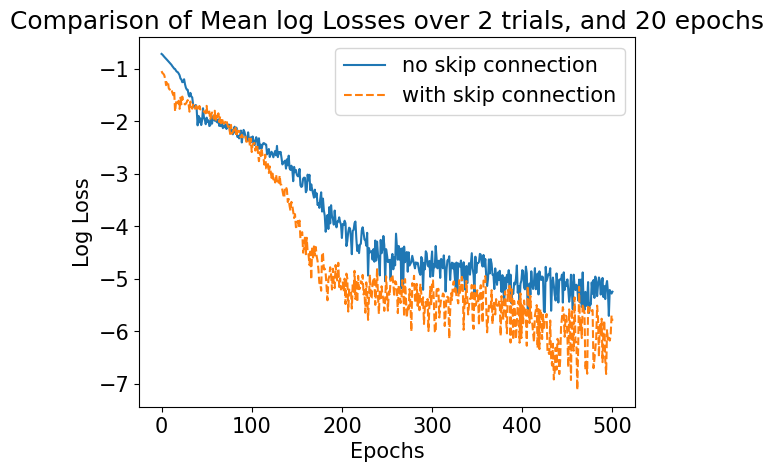

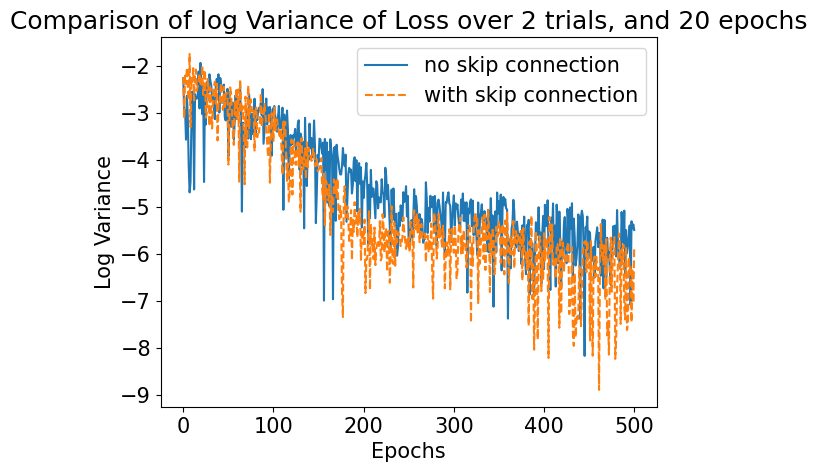

Average training time for no skip connection: 166.264298081398  seconds
Average training time for with skip connection: 149.9036785364151 seconds
Average speedup of skip connection style architecture 1.1091408810292038


In [91]:
#first neural net config, with custom sigmoid. The third layer 
nconfig_1 = {
    "costum_activ": True,
    "sigmoid_activ": True,
    "use_bn1": False,
    "use_bn2": False,
    "activation1": "relu",
    "activation2": "relu",
    "activation3": "None",
    "initializer": tf.keras.initializers.GlorotNormal(),
    "learn_rate": 0.001
}
#second neural net config with custom_sigmoid_2. The third layer is sigmoid activated, and then multiplied by the transformed input through the skip connection
nconfig_2 = {
    "costum_activ": False,
    "sigmoid_activ": False,
    "use_bn1": False,
    "use_bn2": False,
    "activation1": "relu",
    "activation2": "relu",
    "activation3": "sigmoid",
    "initializer": tf.keras.initializers.GlorotNormal(),
    "learn_rate": 0.001
}

tconfig_1= { 
    "k_lb":0.10, 
    "k_ub":1.0,
    "data_generator1": True,
    "show_graph":False,
    "testing":False
}
tconfig_2= { 
    "k_lb":0.10, 
    "k_ub":1.0,
    "data_generator1": True,
    "show_graph":False,
    "testing":False
}

compare_methods(num_trials=2, epochs=501, b_size=20, nn_config_1=nconfig_1, nn_config_2=nconfig_2,
                 train_config_1=tconfig_1 ,train_config_2=tconfig_2, plot_names=("no skip connection", "with skip connection"),test_accuracy=False)

### Comparing the data generation functions

I now want to compare the data generation functions. Since we want the network to learn to approximate the function well on the whole domain space, randomly selecting points from the domain space could potentially lead to bad data out of luck. For example if the early batches happen to be concentrate around a subset, the neural network may learn to predict well that subset, but not others. Then when new data from other regions of the domain are shown, it may lead to more errors. Hence I thought of giving a well distributed sample. The only issue with giving batches of equidistant grid is that it could lead to overfitting if the neural network is exposed to the exact same data points at each batch. To overcome this, I randomly perturb the lower and upper bound of the grid space, to have some variattions in the data. I then shuffle the batch so that it is not always exposed to the same sequence.


To analyze the efficiency of this generating function, I use the same compare function as previously.  I noticed that the loss of the new data generator is much smoother, and has less variance. However I realized that simply looking at the loss would not be able to see how well it evaluates, hence I build a test set, where I make a new random set of values, this time using the previous data generating function, which samples uniformly at random.

I realised that I needed to evaluate how well the neural network could generalize to the general domain. I have only trained the model for values between $[0.1,1]$ but ideally the model should learn the function $\beta \alpha K_t^{\alpha}$ for any values. I hence looked into testing the model for a wider range then the training set. 

I also realized I needed to set a seed to be able to truly see which training data algorithm was more efficient, as I noticed that the initialiazation had a big impact on how well the neural network did in terms of accuracy at the start.


Episode 0, Log10 Loss: -0.7645840644836426
Episode 0, Log10 Acuraccy: -0.02214156836271286


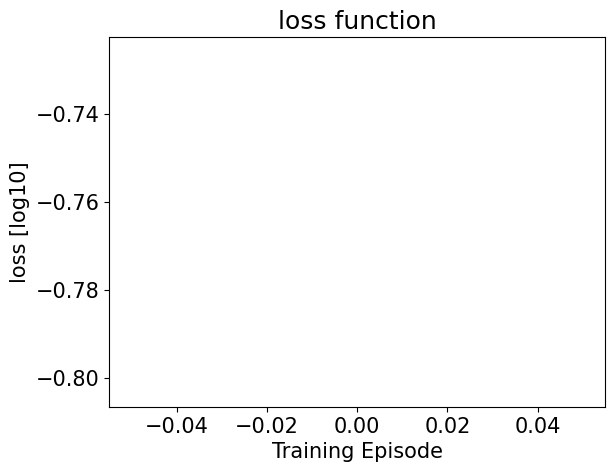

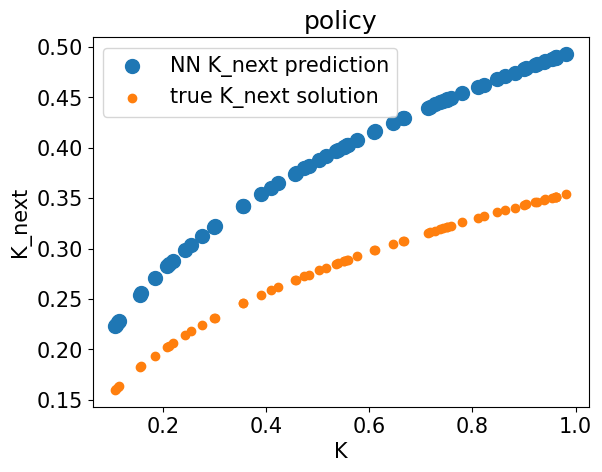

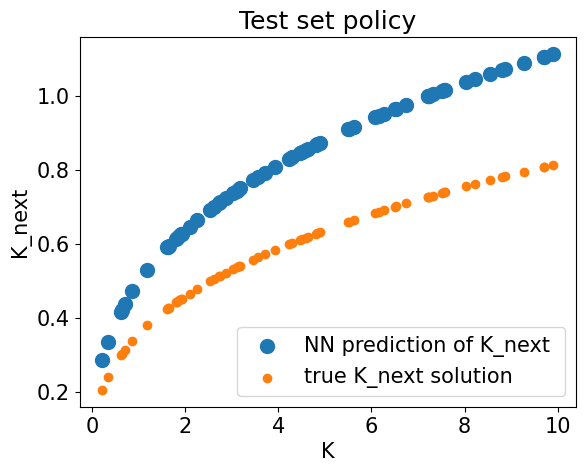

Episode 100, Log10 Loss: -2.280156135559082
Episode 100, Log10 Acuraccy: -0.07893425226211548
Episode 200, Log10 Loss: -4.863836765289307
Episode 200, Log10 Acuraccy: -0.03643973916769028
Episode 300, Log10 Loss: -5.578209400177002
Episode 300, Log10 Acuraccy: -0.03550265356898308
Episode 400, Log10 Loss: -5.989172458648682
Episode 400, Log10 Acuraccy: -0.03649486228823662
Episode 500, Log10 Loss: -6.54061222076416
Episode 500, Log10 Acuraccy: -0.03369281813502312


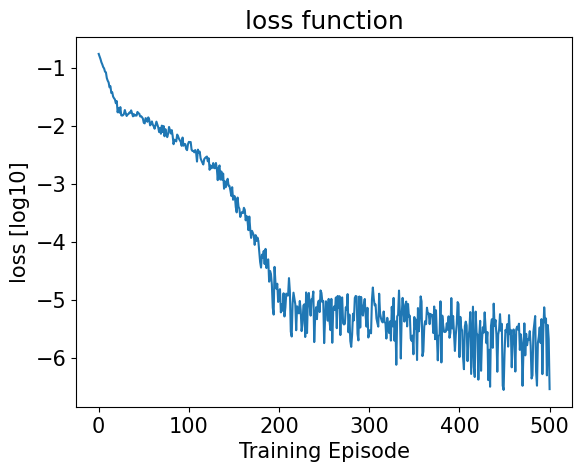

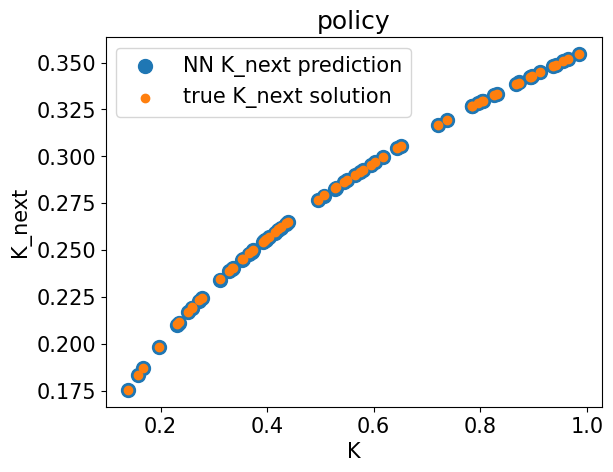

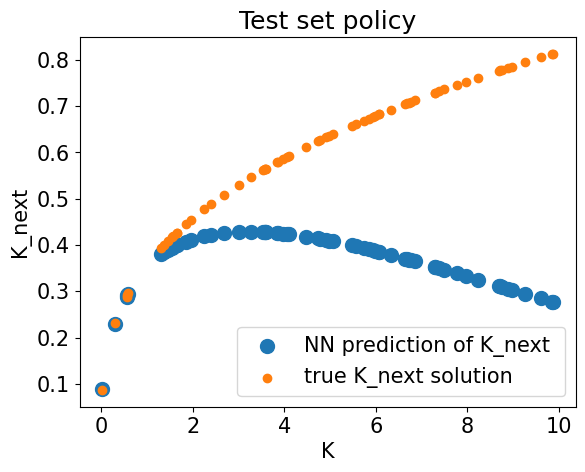

Episode 0, Log10 Loss: -0.7661401033401489
Episode 0, Log10 Acuraccy: -0.0229050125926733


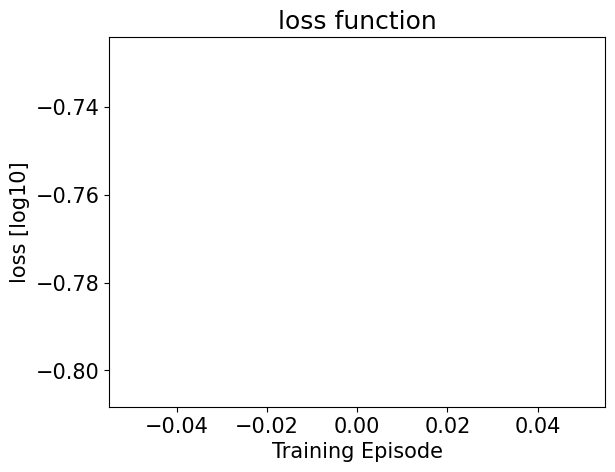

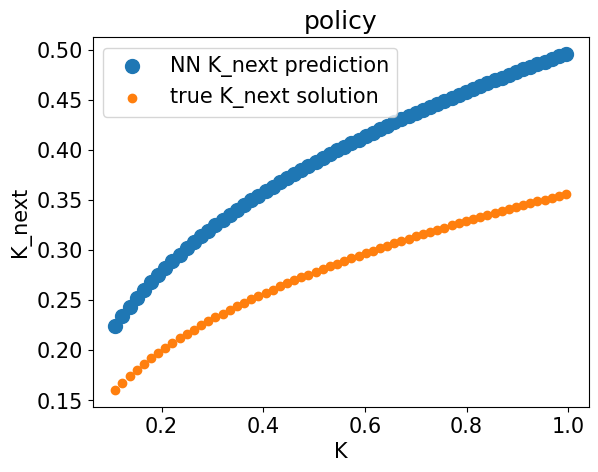

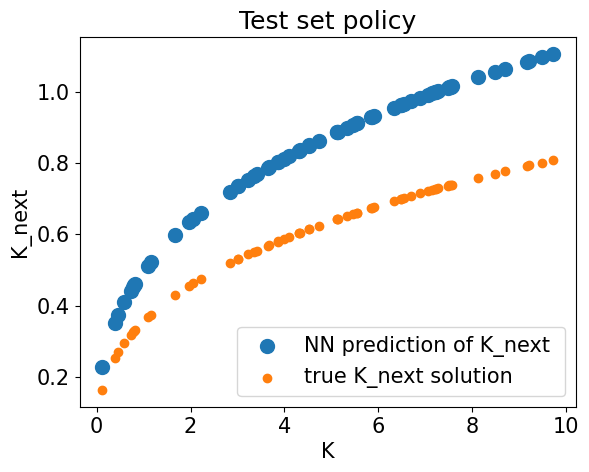

Episode 100, Log10 Loss: -2.371497392654419
Episode 100, Log10 Acuraccy: -0.07959391176700592
Episode 200, Log10 Loss: -4.981095790863037
Episode 200, Log10 Acuraccy: -0.04044192284345627
Episode 300, Log10 Loss: -5.3298821449279785
Episode 300, Log10 Acuraccy: -0.030821412801742554
Episode 400, Log10 Loss: -5.420812129974365
Episode 400, Log10 Acuraccy: -0.039180688560009
Episode 500, Log10 Loss: -5.741326332092285
Episode 500, Log10 Acuraccy: -0.038368068635463715


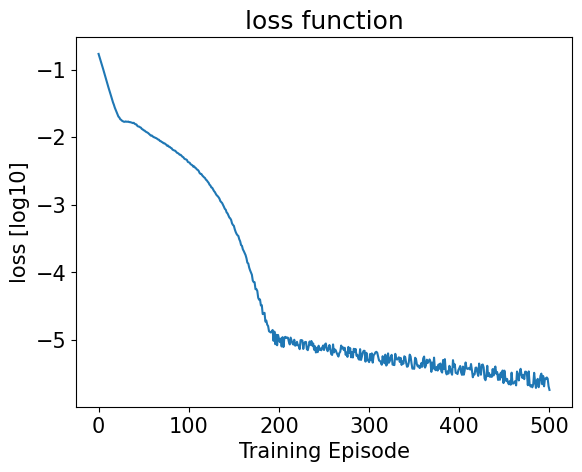

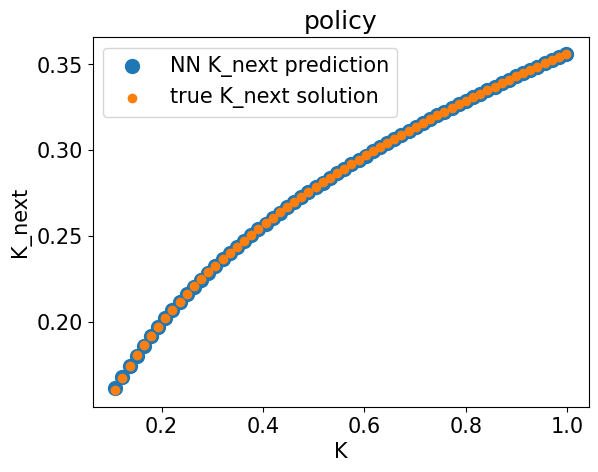

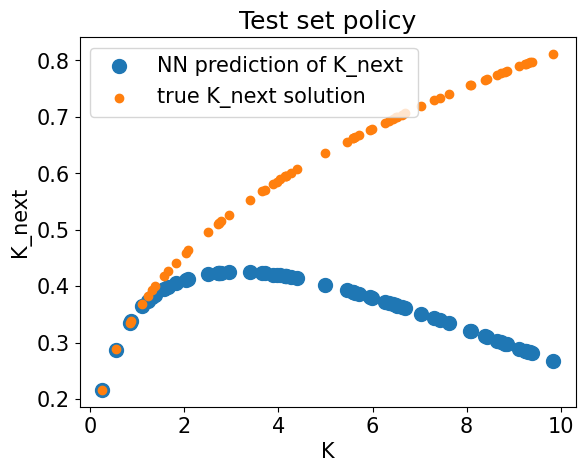

Trial 0
Episode 0, Log10 Loss: -0.767204225063324
Episode 0, Log10 Acuraccy: -0.023139696568250656


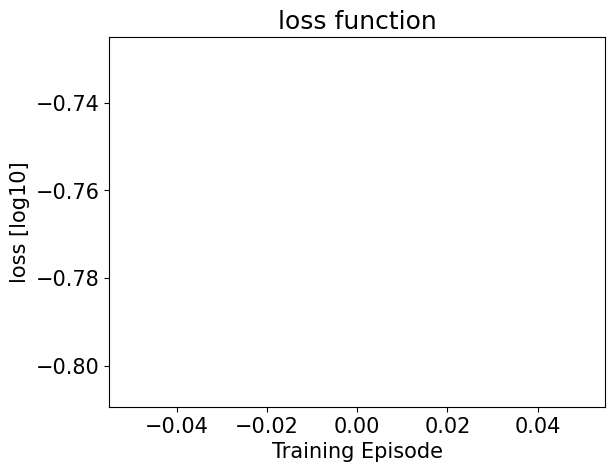

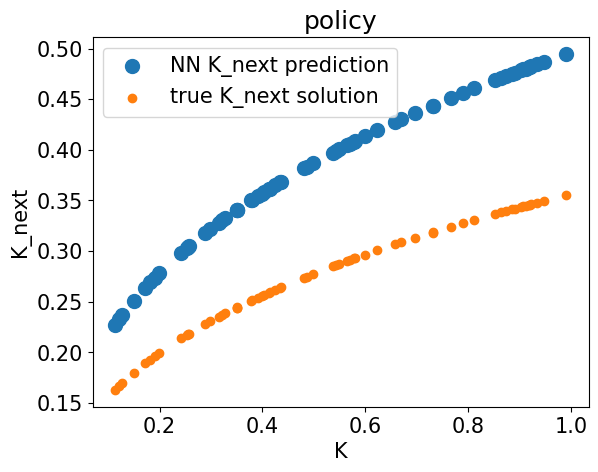

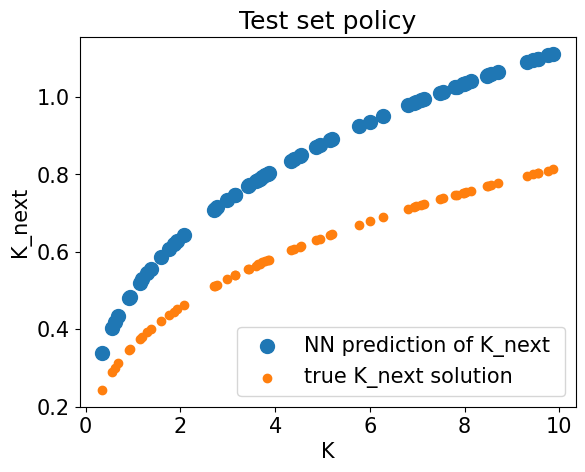

Episode 100, Log10 Loss: -2.4283623695373535
Episode 100, Log10 Acuraccy: -0.07843051850795746
Episode 200, Log10 Loss: -5.051824569702148
Episode 200, Log10 Acuraccy: -0.03872973844408989
Episode 300, Log10 Loss: -4.941723346710205
Episode 300, Log10 Acuraccy: -0.03647005930542946
Episode 400, Log10 Loss: -5.624545097351074
Episode 400, Log10 Acuraccy: -0.03567460551857948
Episode 500, Log10 Loss: -5.609964370727539
Episode 500, Log10 Acuraccy: -0.04435069486498833


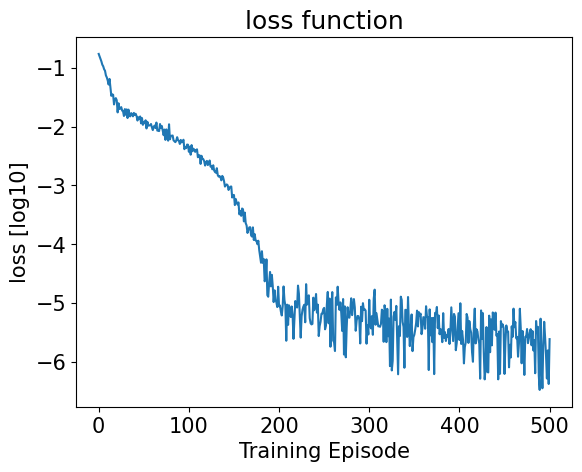

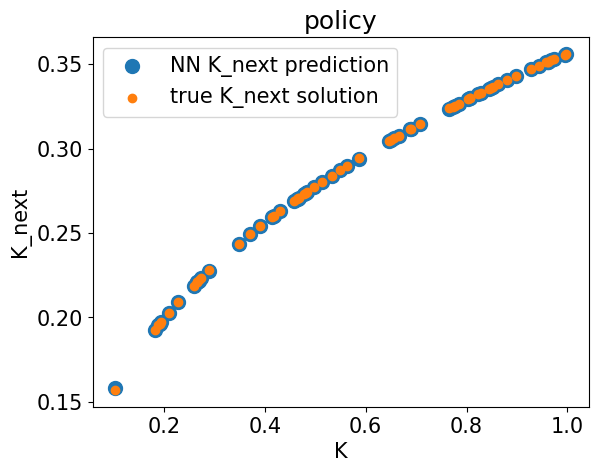

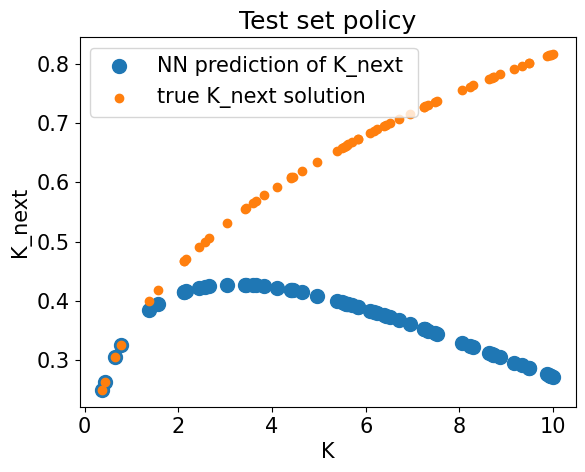

Episode 0, Log10 Loss: -0.7661329507827759
Episode 0, Log10 Acuraccy: -0.023782629519701004


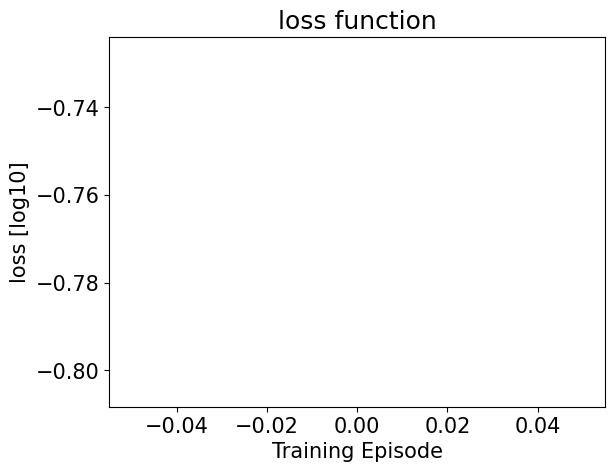

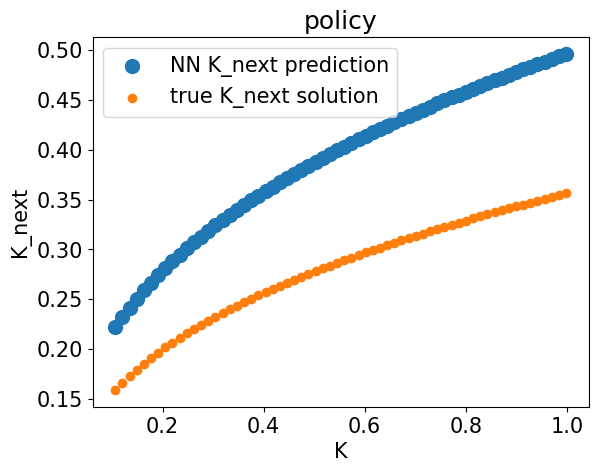

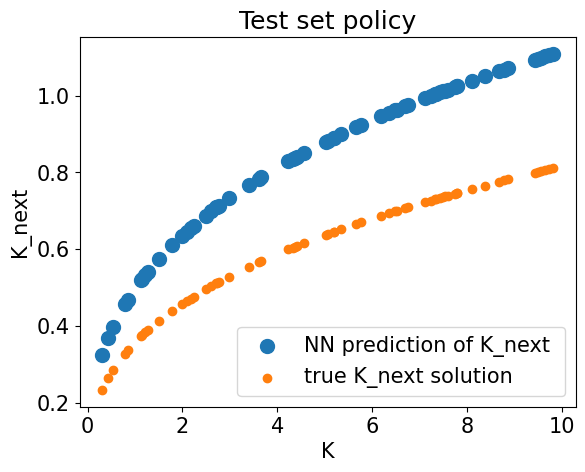

Episode 100, Log10 Loss: -2.3651158809661865
Episode 100, Log10 Acuraccy: -0.07623434066772461
Episode 200, Log10 Loss: -4.984085559844971
Episode 200, Log10 Acuraccy: -0.04274526983499527
Episode 300, Log10 Loss: -5.269036769866943
Episode 300, Log10 Acuraccy: -0.030462071299552917
Episode 400, Log10 Loss: -5.38726806640625
Episode 400, Log10 Acuraccy: -0.02394406497478485
Episode 500, Log10 Loss: -5.574126720428467
Episode 500, Log10 Acuraccy: -0.03375646471977234


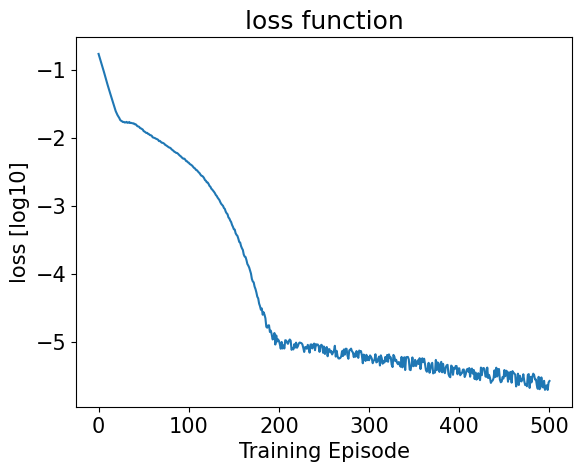

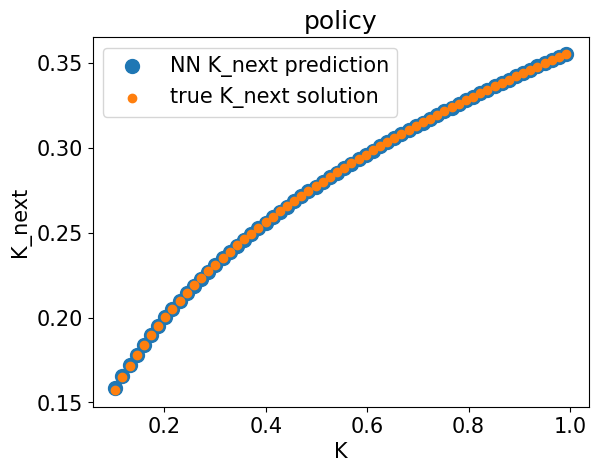

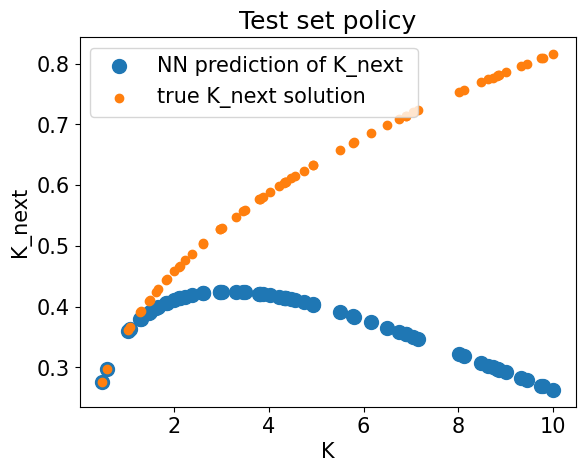

Trial 1


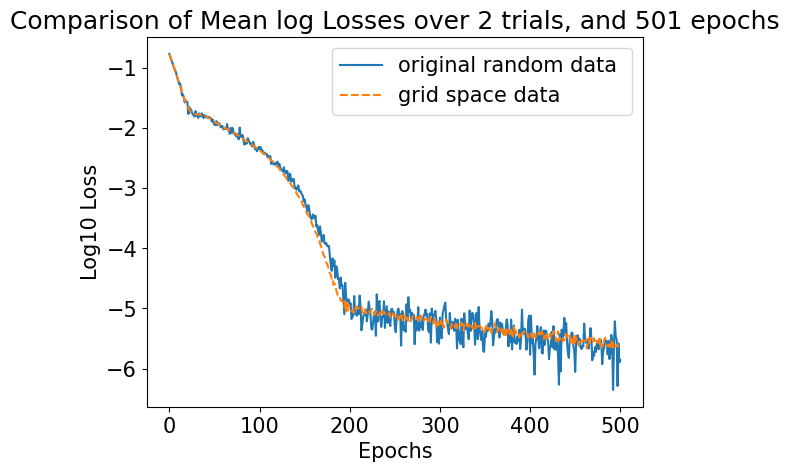

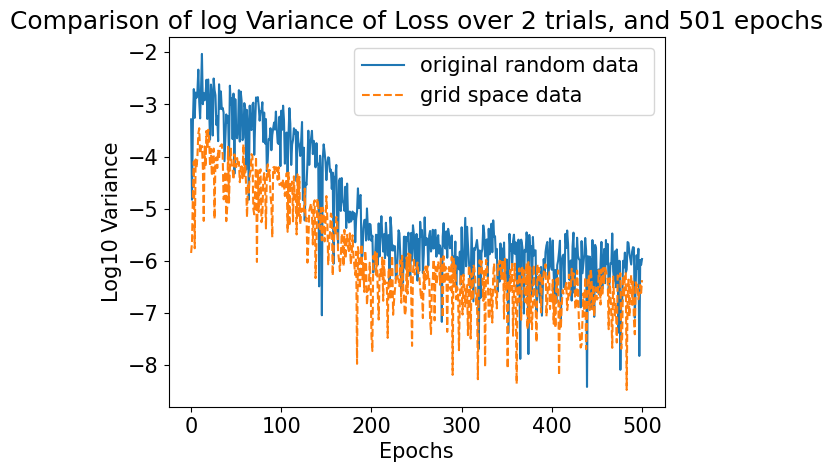

Average training time for original random data : 173.22820568084717  seconds
Average training time for grid space data: 190.14749538898468 seconds
Average speedup of grid space data 0.9110201810782428


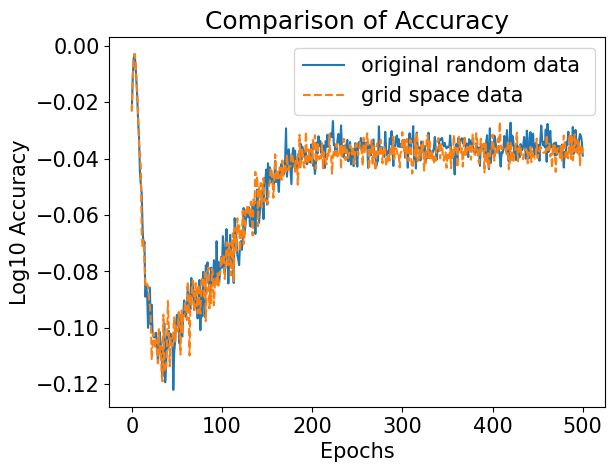

In [184]:
# We use the same neural network configuration for both models
nconfig_1 = {
    "costum_activ": True,
    "sigmoid_activ": True,
    "use_bn1": False,
    "use_bn2": False,
    "activation1": "relu",
    "activation2": "relu",
    "activation3": "None",
    "initializer": tf.keras.initializers.GlorotNormal(seed=42),     #set a seed to ensure robustness of analysis
    "learn_rate": 0.001
}
# We change the training setup to use the different data generators for each model
tconfig_1= { 
    "punish": False,
    "data_generator1": True,      #original data generator
    "show_graph": True,
    "testing": True,
    "test_lb": 0,           #test set lower bound
    "test_ub": 10           #test set upper bound  
}

tconfig_2= { 
    "punish": False,
    "data_generator1": False,  # new grid space generator
    "show_graph":True,
    "testing": True,
    "test_lb": 0,
    "test_ub": 10
}

compare_methods(num_trials=2, epochs=501, b_size=64, nn_config_1=nconfig_1, nn_config_2=nconfig_1,
                 train_config_1=tconfig_1 ,train_config_2=tconfig_2, plot_names=("original random data ", "grid space data"),test_accuracy=True)

### Comparing punishment with activation
I next want to compare whether adding punishment can improve my results, and how a sigmoid activation with punishment can compare to my activation function. I use again the compare function to do this. We can see below that the results are far different. This pushed me to compare how efficient the punishment was compared to no punishment. 

Episode 0, Log10 Loss: -0.7673582434654236


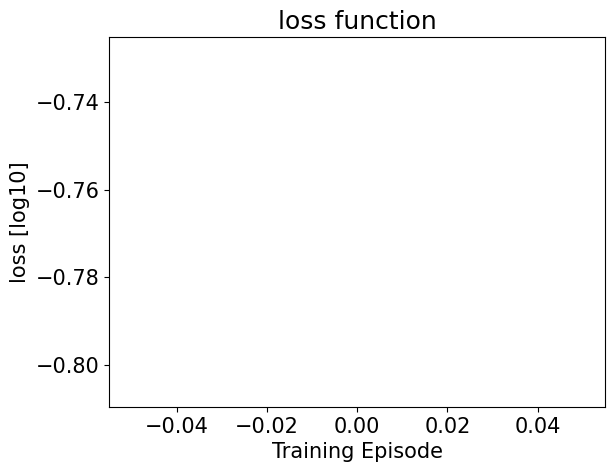

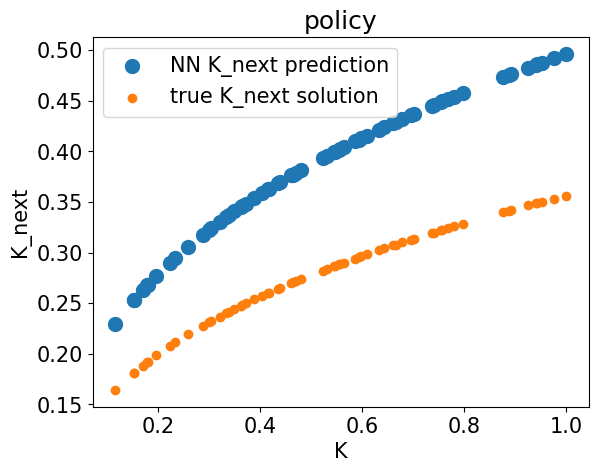

Episode 100, Log10 Loss: -2.374377727508545
Episode 200, Log10 Loss: -4.925936698913574
Episode 300, Log10 Loss: -5.4917988777160645
Episode 400, Log10 Loss: -6.395761966705322
Episode 500, Log10 Loss: -6.582147598266602


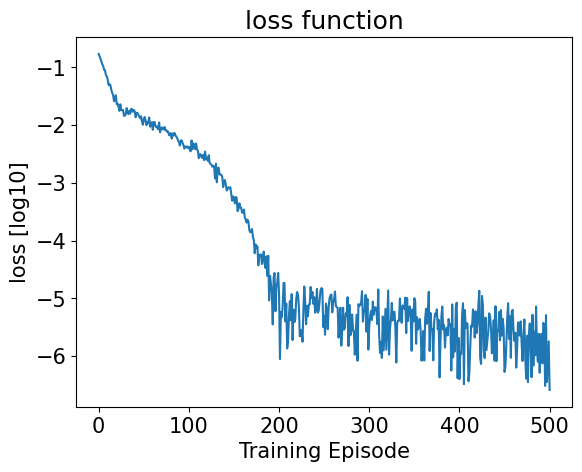

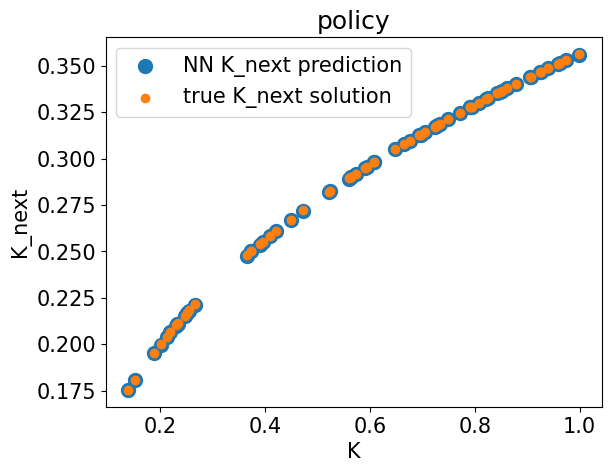

Episode 0, Log10 Loss: 0.431819349527359


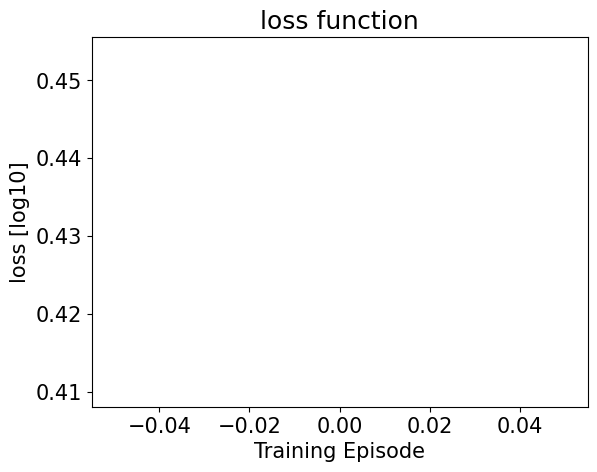

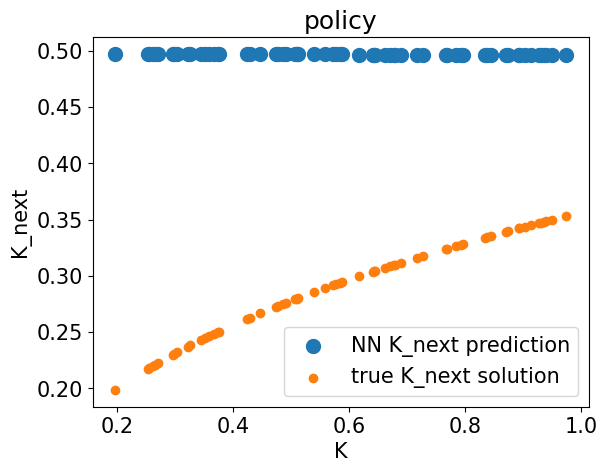

Episode 100, Log10 Loss: 5.2951436042785645
Episode 200, Log10 Loss: 0.5978896021842957
Episode 300, Log10 Loss: 0.6958715319633484
Episode 400, Log10 Loss: 1.1412795782089233
Episode 500, Log10 Loss: 0.13502401113510132


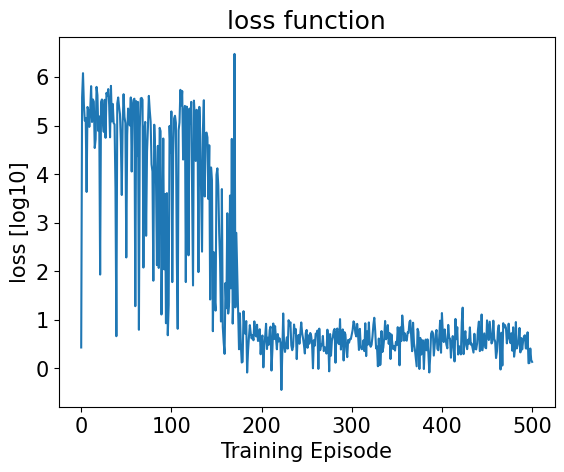

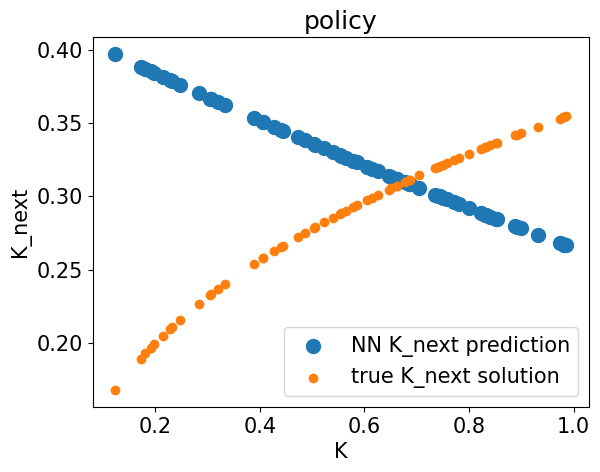

Trial 0
Episode 0, Log10 Loss: -0.7668939828872681


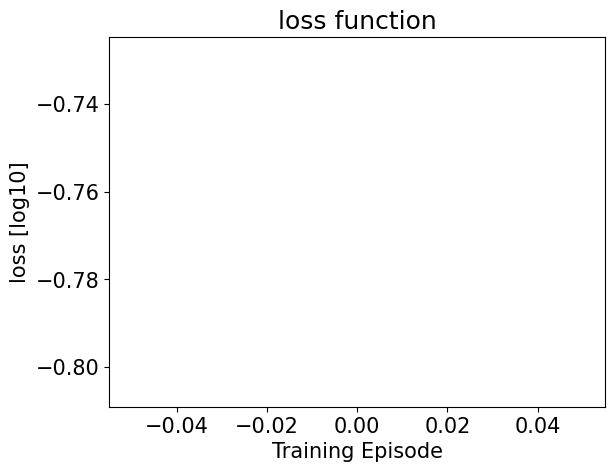

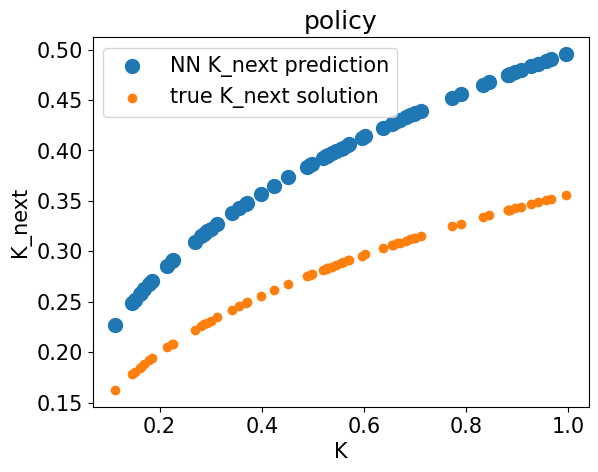

Episode 100, Log10 Loss: -2.2419962882995605
Episode 200, Log10 Loss: -4.917665481567383
Episode 300, Log10 Loss: -5.208118915557861
Episode 400, Log10 Loss: -5.068908214569092
Episode 500, Log10 Loss: -5.551850318908691


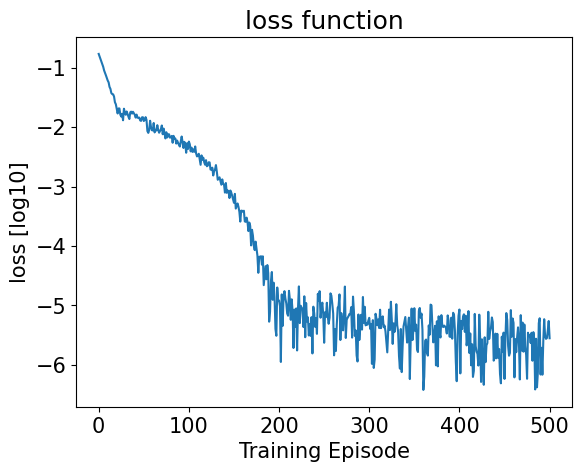

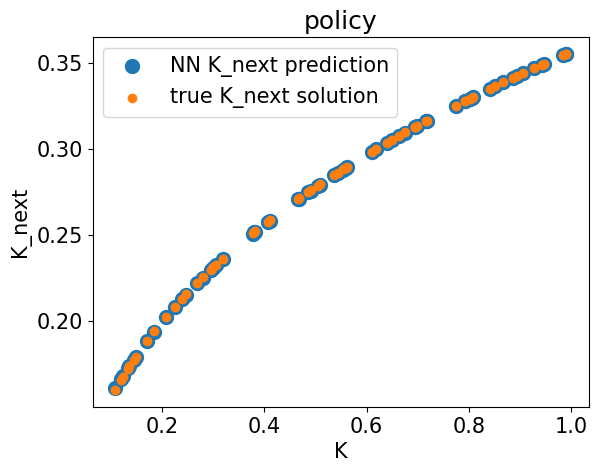

Episode 0, Log10 Loss: 5.879759311676025


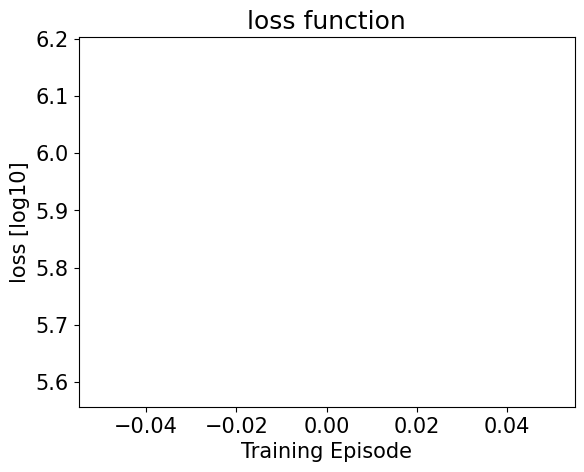

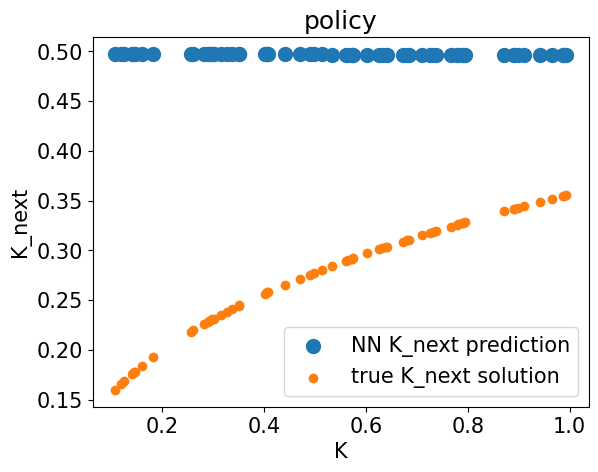

Episode 100, Log10 Loss: 1.0626014471054077
Episode 200, Log10 Loss: 0.8956819772720337
Episode 300, Log10 Loss: 0.21316394209861755
Episode 400, Log10 Loss: 4.34157133102417
Episode 500, Log10 Loss: 5.658664703369141


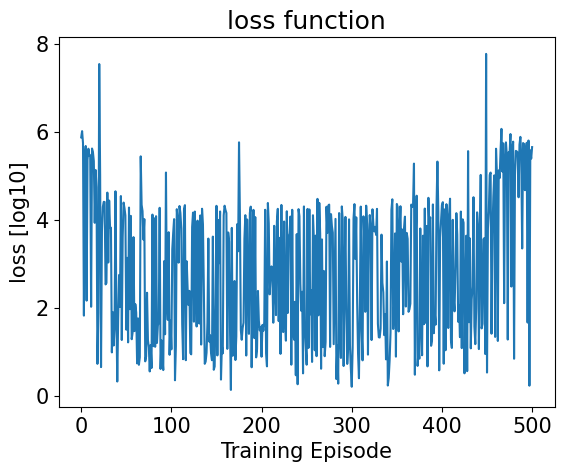

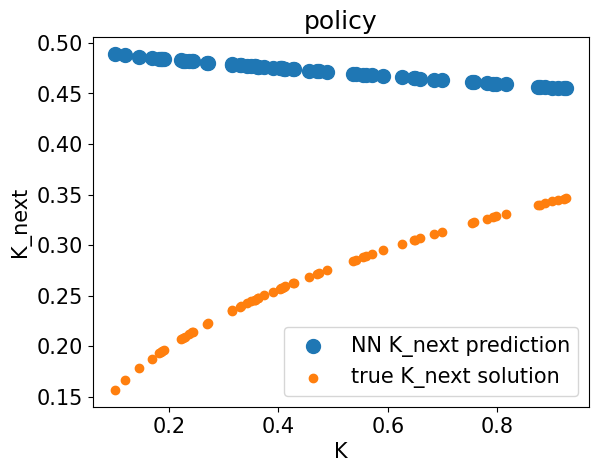

Trial 1


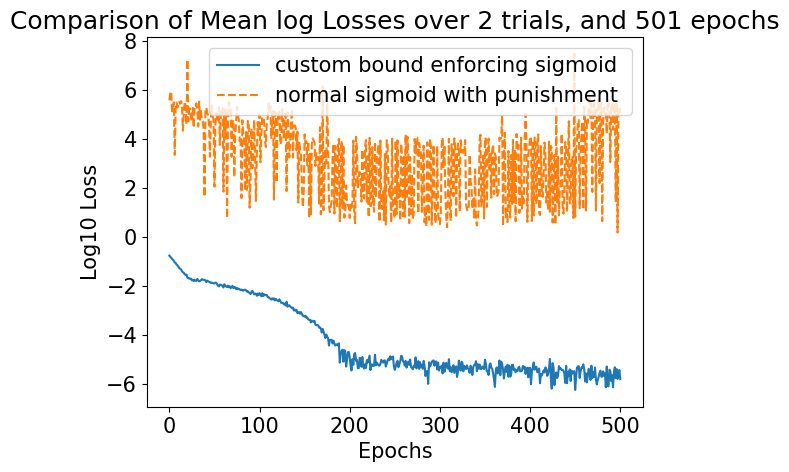

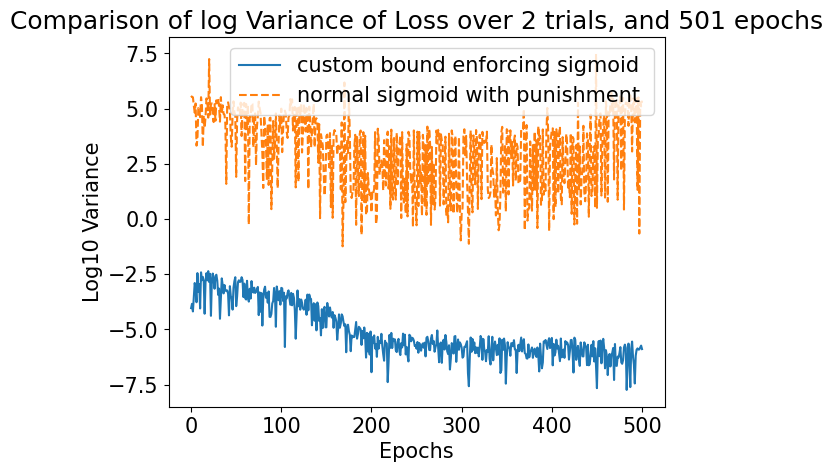

Average training time for custom bound enforcing sigmoid : 213.09379935264587  seconds
Average training time for normal sigmoid with punishment: 151.49143052101135 seconds
Average speedup of normal sigmoid with punishment 1.4066392971521282


In [194]:
# We use the same neural network configuration for both models
nconfig_1 = {
    "costum_activ": True,
    "sigmoid_activ": True,
    "use_bn1": False,
    "use_bn2": False,
    "activation1": "relu",
    "activation2": "relu",
    "activation3": "None",
    "initializer": tf.keras.initializers.GlorotNormal(seed=42),     #set a seed to ensure robustness of analysis
    "learn_rate": 0.001
}
nconfig_2 = {
    "costum_activ": False,
    "sigmoid_activ": False,
    "use_bn1": False,
    "use_bn2": False,
    "activation1": "relu",
    "activation2": "relu",
    "activation3": "sigmoid",
    "initializer": tf.keras.initializers.GlorotNormal(seed=42),     #set a seed to ensure robustness of analysis
    "learn_rate": 0.001
}
# We change the training setup to use the different data generators for each model
tconfig_1= { 
    "punish": False,
    "data_generator1": True,      #original data generator
    "show_graph": True,
    "testing": False,
}

tconfig_2= { 
    "punish": True,
    "data_generator1": True,  # new grid space generator
    "show_graph":True,
    "testing": False,
}

compare_methods(num_trials=2, epochs=501, b_size=64, nn_config_1=nconfig_1, nn_config_2=nconfig_2,
                 train_config_1=tconfig_1 ,train_config_2=tconfig_2, plot_names=("custom bound enforcing sigmoid ", "normal sigmoid with punishment"),test_accuracy=False)

Episode 0, Log10 Loss: 2.7116219997406006


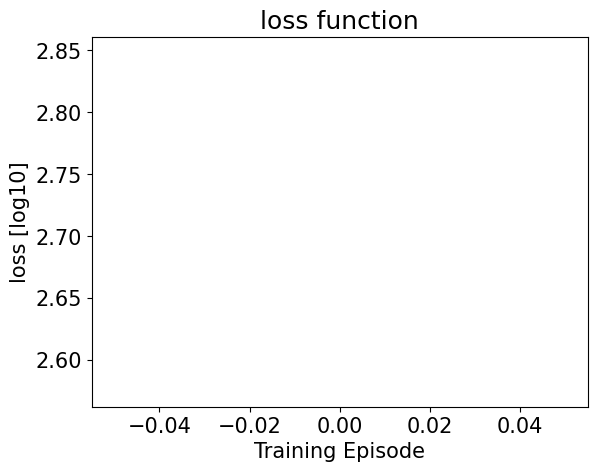

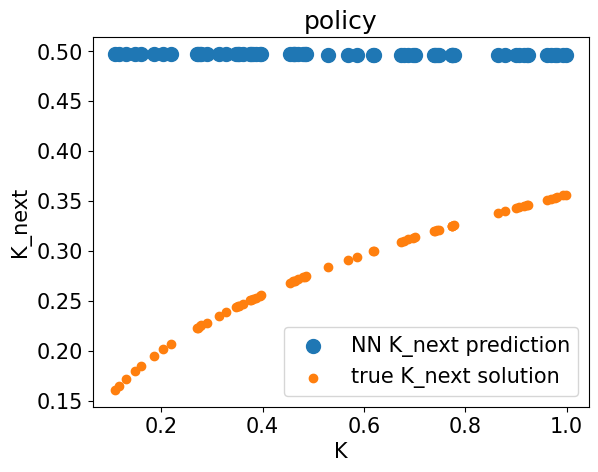

Episode 100, Log10 Loss: 2.440777063369751
Episode 200, Log10 Loss: 3.442906379699707
Episode 300, Log10 Loss: 0.7743473052978516
Episode 400, Log10 Loss: 0.436672568321228
Episode 500, Log10 Loss: 0.5754083395004272


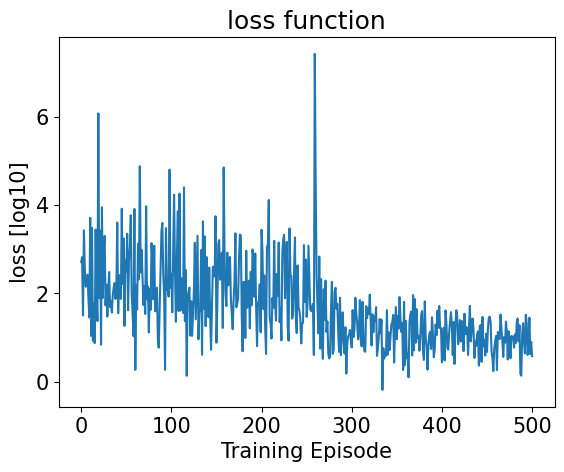

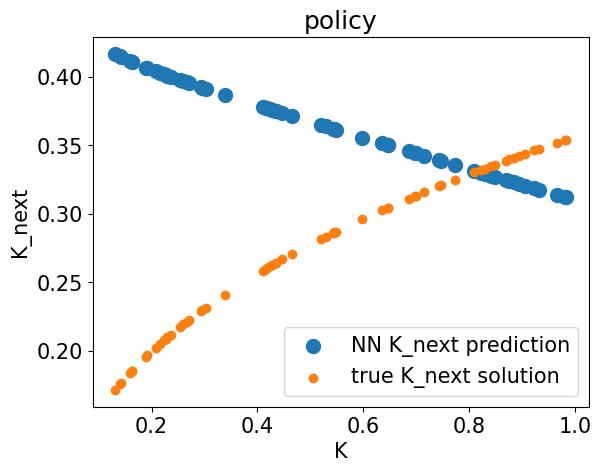

Episode 0, Log10 Loss: 5.823568820953369


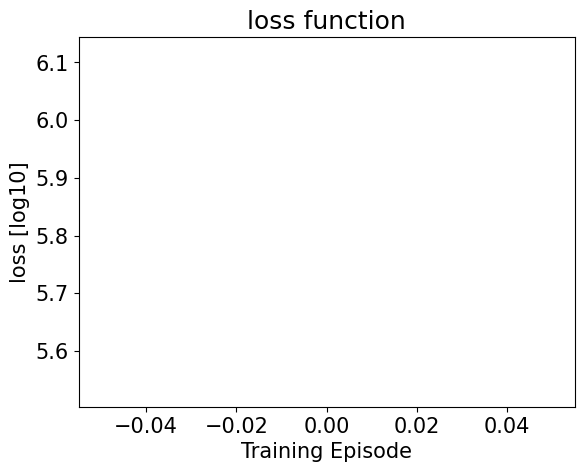

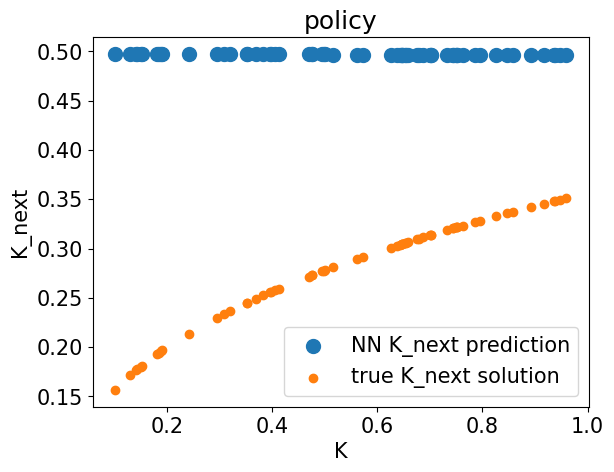

Episode 100, Log10 Loss: 6.100701332092285
Episode 200, Log10 Loss: 6.229551792144775
Episode 300, Log10 Loss: 5.65661096572876
Episode 400, Log10 Loss: 5.6422343254089355
Episode 500, Log10 Loss: 5.326784610748291


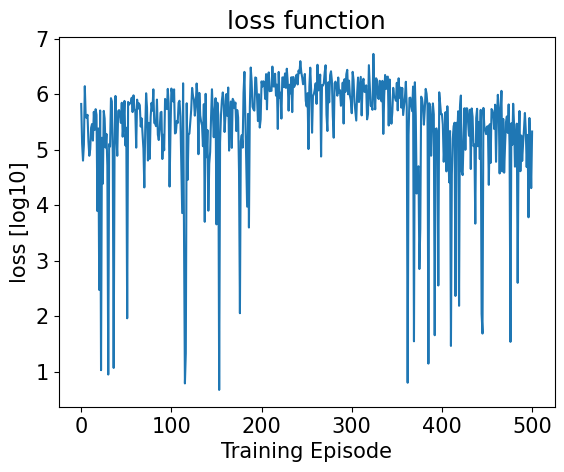

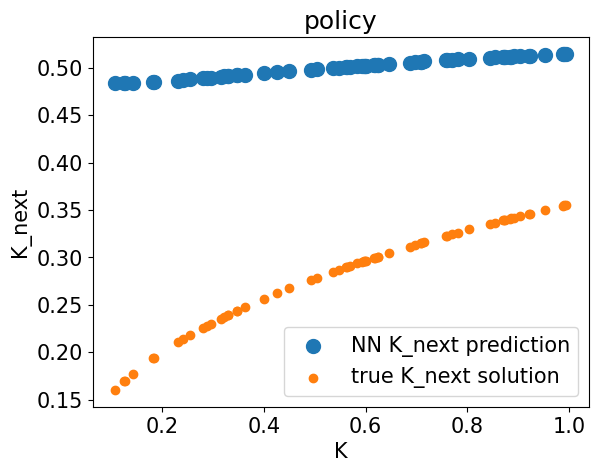

Trial 0
Episode 0, Log10 Loss: 2.6342272758483887


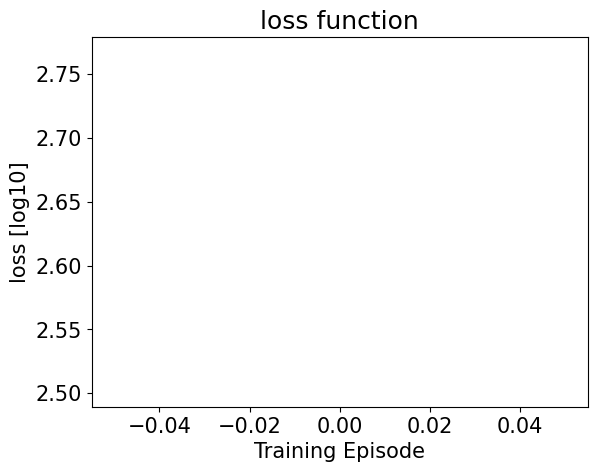

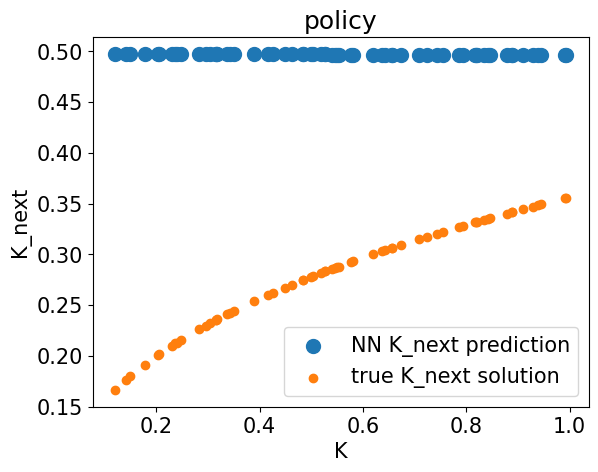

Episode 100, Log10 Loss: 3.035667657852173
Episode 200, Log10 Loss: 2.2298078536987305
Episode 300, Log10 Loss: 1.7211700677871704
Episode 400, Log10 Loss: 3.6716625690460205
Episode 500, Log10 Loss: 1.0130044221878052


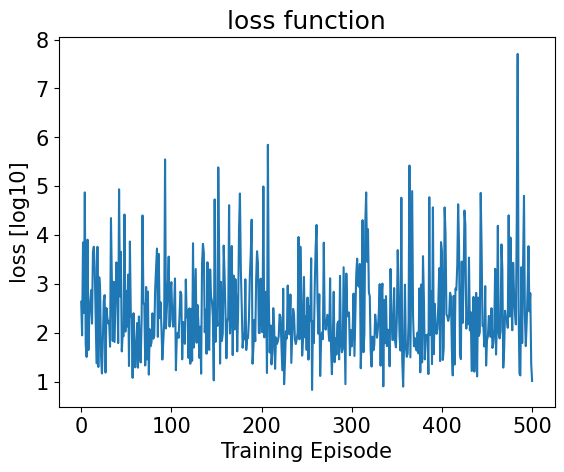

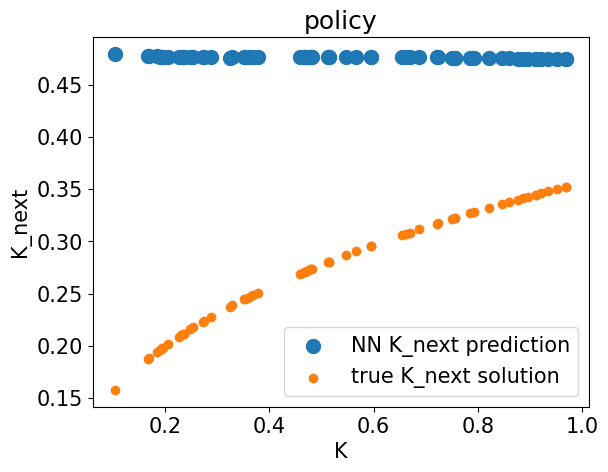

Episode 0, Log10 Loss: 5.519543170928955


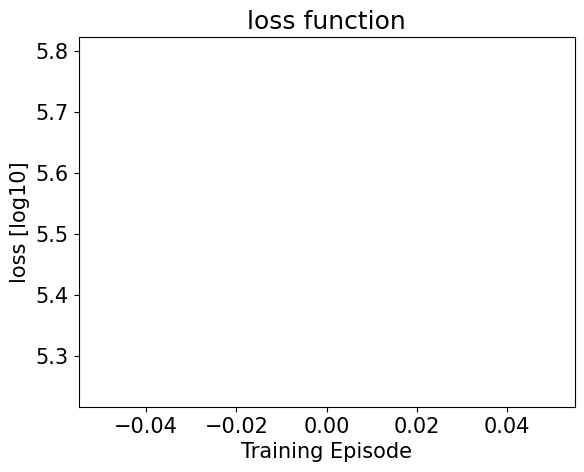

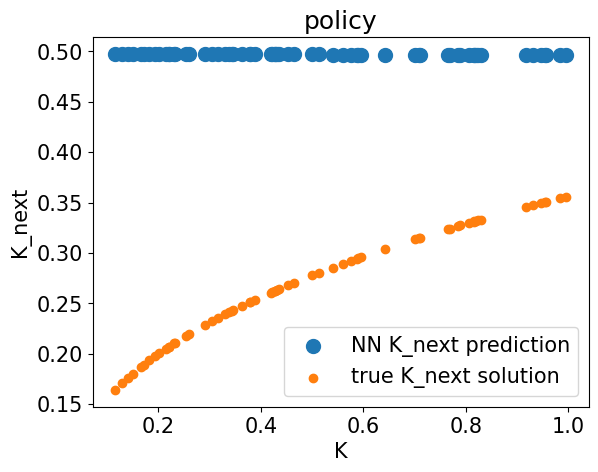

Episode 100, Log10 Loss: 1.6646597385406494
Episode 200, Log10 Loss: 1.7693028450012207
Episode 300, Log10 Loss: 0.7704065442085266
Episode 400, Log10 Loss: 1.2417771816253662
Episode 500, Log10 Loss: 1.2004228830337524


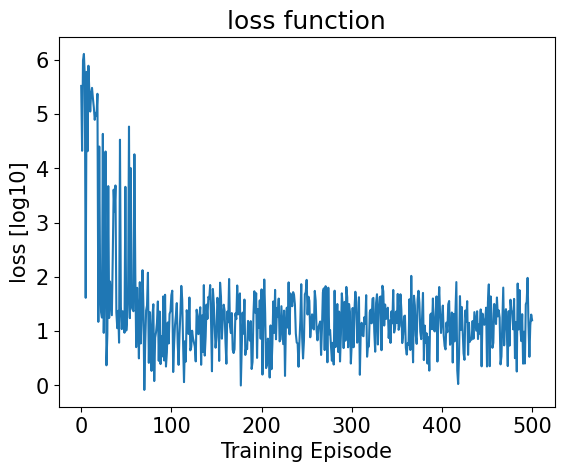

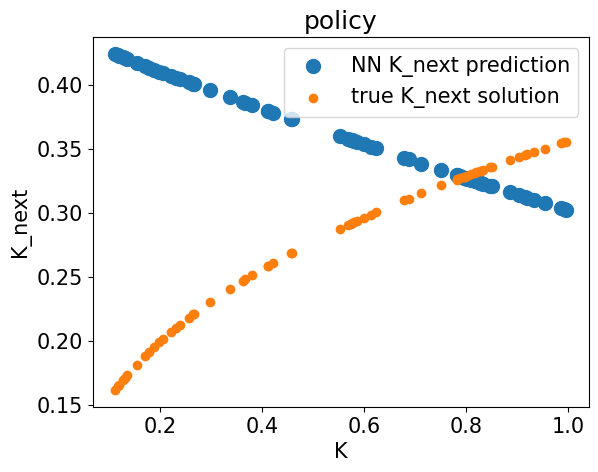

Trial 1


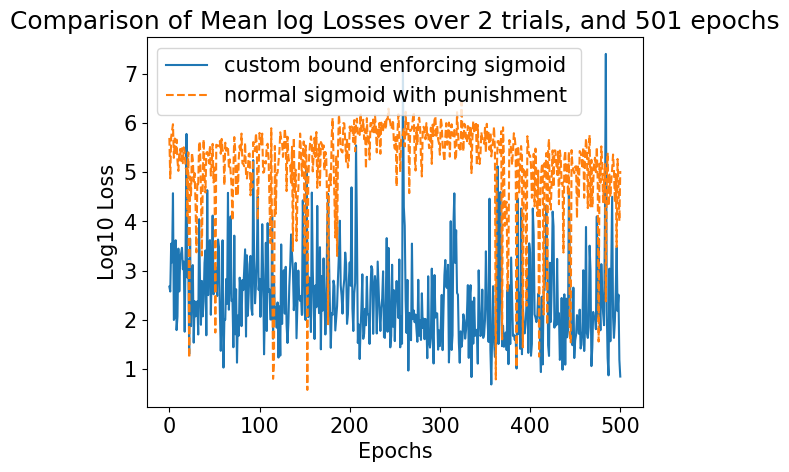

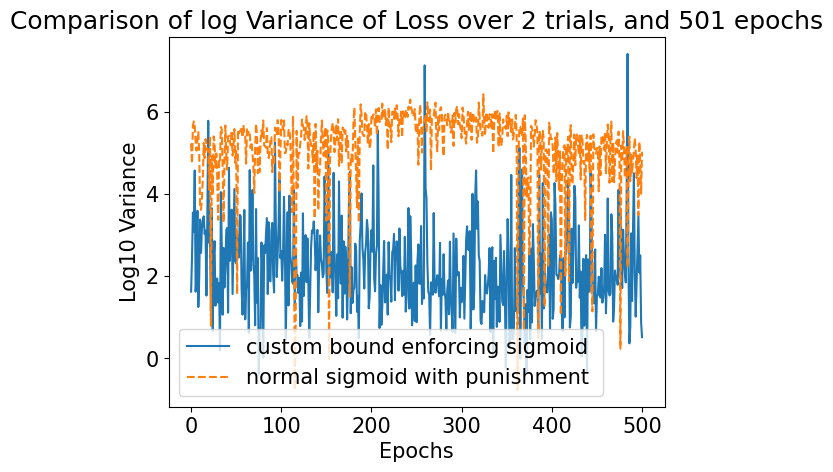

Average training time for custom bound enforcing sigmoid : 218.17470276355743  seconds
Average training time for normal sigmoid with punishment: 197.27851855754852 seconds
Average speedup of normal sigmoid with punishment 1.105922248194059


In [196]:
# We use the same neural network configuration for both models
nconfig_1 = {
    "costum_activ": False,
    "sigmoid_activ": False,
    "use_bn1": False,
    "use_bn2": False,
    "activation1": "relu",
    "activation2": "relu",
    "activation3": "sigmoid",
    "initializer": tf.keras.initializers.GlorotNormal(seed=42),     #set a seed to ensure robustness of analysis
    "learn_rate": 0.001
}
nconfig_2 = {
    "costum_activ": False,
    "sigmoid_activ": False,
    "use_bn1": False,
    "use_bn2": False,
    "activation1": "relu",
    "activation2": "relu",
    "activation3": "sigmoid",
    "initializer": tf.keras.initializers.GlorotNormal(seed=42),     #set a seed to ensure robustness of analysis
    "learn_rate": 0.001
}
# We change the training setup to use the different data generators for each model
tconfig_1= { 
    "punish": False,
    "data_generator1": True,      #original data generator
    "show_graph": True,
    "testing": False,
}

tconfig_2= { 
    "punish": True,
    "data_generator1": True,  # new grid space generator
    "show_graph":True,
    "testing": False,
}

compare_methods(num_trials=2, epochs=501, b_size=64, nn_config_1=nconfig_1, nn_config_2=nconfig_2,
                 train_config_1=tconfig_1 ,train_config_2=tconfig_2, plot_names=("custom bound enforcing sigmoid ", "normal sigmoid with punishment"),test_accuracy=False)